In [1]:
# ==========================================
# 0. IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, roc_auc_score, auc)
from imblearn.over_sampling import SMOTE
import pickle
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("="*70)
print("PREDIKSI OBESITAS SISWA SMA/SMK - MACHINE LEARNING")
print("="*70)
print("Semua libraries berhasil dimuat!")

PREDIKSI OBESITAS SISWA SMA/SMK - MACHINE LEARNING
Semua libraries berhasil dimuat!


In [3]:
# ==========================================
# 1. DATA COLLECTION (PENGUMPULAN DATA)
# ==========================================
print("\n" + "="*70)
print("TAHAP 1: DATA COLLECTION (PENGUMPULAN DATA)")
print("="*70)

# Load dataset
df = pd.read_csv(r"C:\Users\ANISETUS B. MANALU\kelompok_06\data\dataset_mentah.csv", 
                 encoding='latin1')
print(f"Data berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")

# Tampilkan semua kolom
print("\nDaftar Kolom:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

# Drop kolom yang completely empty
df = df.dropna(axis=1, how="all")
print(f"\nKolom kosong dihapus: Sisa {df.shape[1]} kolom")

# Info dataset
print(f"\nInformasi Dataset:")
print(f"  Jumlah baris: {df.shape[0]}")
print(f"  Jumlah kolom: {df.shape[1]}")
print(f"  Missing values total: {df.isnull().sum().sum()}")
print(f"  Duplikat: {df.duplicated().sum()}")


TAHAP 1: DATA COLLECTION (PENGUMPULAN DATA)
Data berhasil dimuat: 2505 baris, 26 kolom

Daftar Kolom:
  1. Timestamp
  2. Nama lengkap
  3. Jenis Kelamin
  4. Usia
  5. Jalur Pendidikan
  6. Asal Sekolah
  7. Kelas
  8. Berapa berat badan kamu sekarang? (dalam kilogram)
  9. Berapa tinggi badan kamu sekarang? (dalam centimeter)
  10. Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari?
  11. Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?
  12. Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji
  13. Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?
  14. Secara umum, jenis makanan apa yang paling sering kamu konsumsi?
  15. Berapa kali kamu berolahraga dalam seminggu?
  16. Jika kamu berolahraga, rata-rata berapa menit durasi tiap kali olahraga?
  17. Seberapa sering kamu dalam melakukan aktivitas fisik sehar

In [4]:
# mengecek di kolom mana dan handle missing dengan median/mode

# Hitung jumlah NaN per kolom
nan_kolom_perhitungan = df.isnull().sum()

# Filter hanya kolom yang memiliki NaN (> 0) dan simpan namanya dalam list
kolom_dengan_nan = nan_kolom_perhitungan[nan_kolom_perhitungan > 0].index.tolist()

print("-" * 50)
for col in kolom_dengan_nan:
    # Cek tipe data: Jika numerik (angka), gunakan Median
    if pd.api.types.is_numeric_dtype(df[col]):
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Kolom Numerik '{col}' diisi dengan MEDIAN: {median_value:.2f}")
    
    # Cek tipe data: Jika kategorikal/teks, gunakan Mode
    elif pd.api.types.is_object_dtype(df[col]):
        try:
            mode_value = df[col].mode()[0]
        except IndexError:
            mode_value = "NULL_FILLED" 
        df[col].fillna(mode_value, inplace=True)
        print(f"Kolom Kategorikal '{col}' \ndiisi dengan MODE: {mode_value}")
    else:
        # Jika ada tipe data lain (misalnya boolean)
        print(f"Kolom '{col}' tidak diimputasi karena tipe data tidak dikenal.")

--------------------------------------------------
Kolom Kategorikal 'Apakah di lingkungan rumah/sekolah kamu ada fasilitas olahraga (lapangan, gym, tempat lari, dll)?' 
diisi dengan MODE: Ya, mudah diakses


In [5]:
# ==========================================
# 2. DATA CLEANING & PREPROCESSING
# ==========================================
print("\n" + "="*70)
print("TAHAP 2: DATA CLEANING & PREPROCESSING")
print("="*70)

# 2.1 Fungsi untuk membersihkan angka dengan satuan
def clean_numeric(val):
    """Membersihkan nilai numerik dengan satuan (kg, cm, tahun)"""
    if pd.isna(val):
        return np.nan
    val = str(val).lower()
    for unit in ["kg", "cm", "tahun", "th", "jam", "kilogram", "centimeter"]:
        val = val.replace(unit, "")
    val = val.replace(",", ".").strip()
    try:
        return float(val)
    except:
        return np.nan

print("Fungsi pembersih numerik dibuat")


TAHAP 2: DATA CLEANING & PREPROCESSING
Fungsi pembersih numerik dibuat


In [6]:
# 2.2 Mapping kategori → nilai numerik (STANDARDIZED)
mapping_tidur = {
    "< 5 jam": 4,
    "5-6 jam": 5.5,
    "5–6 jam": 5.5,
    "5 - 6 jam": 5.5,
    "7-8 jam": 7.5,
    "7 -8 jam": 7.5,
    "7 - 8 jam": 7.5,
    "> 8 jam": 9
}

mapping_makan = {
    "1 kali": 1,
    "2 kali": 2,
    "3 kali": 3,
    "> 3 kali": 4
}

mapping_jajan = {
    "0 - 2 kali": 1,
    "0-2 kali": 1,
    "3 - 5 kali": 4,
    "3-5 kali": 4,
    "4 - 5 kali": 4.5,
    "6 - 10 kali": 8,
    "6-10 kali": 8,
    "> 10 kali": 12,
    "> 10  kali": 12,
    ">10 kali": 12
}

mapping_fastfood = {
    "0 - 2 kali": 1,
    "0-2 kali": 1,
    "3 - 5 kali": 4,
    "3-5 kali": 4,
    "3 -  5 kali": 4,
    "> 5 kali": 7,
    ">5 kali": 7
}

mapping_minuman = {
    "0 - 2 gelas": 1,
    "0-2 gelas": 1,
    "3 - 5 gelas": 4,
    "3-5 gelas": 4,
    "6 - 10 gelas": 8,
    "6-10 gelas": 8,
    "10 - 6 gelas": 8,
    "10 gelas": 10,
    "> 10 gelas": 12,
    ">10 gelas": 12,
    ">10gelas": 12
}

mapping_makan_malam = {
    "0 Kali": 0,
    "0 kali": 0,
    "1 Kali": 1,
    "1 kali": 1,
    "2 - 3 kali": 2.5,
    "2 - 3 Kali": 2.5,
    "2-3 kali": 2.5,
    "2 -  3 Kali": 2.5,
    "4 kali": 4,
    "5 Kali": 5,
    "> 4 kali": 6,
    "> 4 Kali": 6,
    ">4 kali": 6,
    "4 kali atau lebih": 6
}

mapping_frekuensi_olahraga = {
    "Tidak pernah": 0,
    "1 - 2 kali": 1.5,
    "1-2 kali": 1.5,
    "3 - 4 kali": 3.5,
    "3-4 kali": 3.5,
    "5 - 7 kali": 6,
    "5-7 kali": 6,
    "> 7 kali": 8
}

mapping_durasi_olahraga = {
    "< 15 menit": 10,
    "<15 menit": 10,
    "15 - 30 menit": 22.5,
    "15-30 menit": 22.5,
    "31 -60 menit": 45,
    "31 - 60 menit": 45,
    "30-60 menit": 45,
    "> 60 menit": 75,
    ">60 menit": 75
}

mapping_video_makanan={
    "tidak pernah":0,
    "Tidak pernah":0,
    "< 1 jam per minggu":0.5,
    "1-3 jam per minggu":2,
    "1 - 3 jam per minggu":2,
    "4-6 jam per minggu":5,
    "4 - 6 jam per minggu":5,
    "7-10 jam per minggu":8.5,
    "7 - 10 jam per minggu":8.5,
    "10 jam per minggu":10  
}

print("Mapping kategori dibuat")



Mapping kategori dibuat


In [7]:
# 2.3 Bersihkan kolom numerik dasar
col_berat = "Berapa berat badan kamu sekarang? (dalam kilogram)"
col_tinggi = "Berapa tinggi badan kamu sekarang? (dalam centimeter)"

df["berat_kg"] = df[col_berat].apply(clean_numeric)
df["tinggi_cm"] = df[col_tinggi].apply(clean_numeric)
df["usia_tahun"] = df["Usia"].apply(clean_numeric)

print(f"Kolom numerik dibersihkan:")
print(f"  - berat_kg: {df['berat_kg'].notna().sum()} valid values")
print(f"  - tinggi_cm: {df['tinggi_cm'].notna().sum()} valid values")
print(f"  - usia_tahun: {df['usia_tahun'].notna().sum()} valid values")


Kolom numerik dibersihkan:
  - berat_kg: 2464 valid values
  - tinggi_cm: 2458 valid values
  - usia_tahun: 2457 valid values


In [8]:
# 2.4 Terapkan mapping ke kolom-kolom kategorikal
col_makan_utama = "Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari?"
col_jajan = "Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?"
col_fastfood = "Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji"
col_minuman = "Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?"
col_tidur = "Rata-rata, berapa jam kamu tidur setiap malam?"
col_olahraga = "Berapa kali kamu berolahraga dalam seminggu?"
col_durasi_olahraga = "Jika kamu berolahraga, rata-rata berapa menit durasi tiap kali olahraga?"
col_aktivitas = "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik turun tangga, kegiatan di rumah/sekolah)?"
col_stres = "Seberapa sering kamu merasa stres (karena tugas, sekolah, keluarga, dsb)?"
col_teman = "Seberapa besar pengaruh teman terhadap kebiasaan kamu jajan/makan (misalnya diajak nongkrong, makan bersama)?"
col_keluarga = "Apakah ada keluarga Anda yang pernah atau sedang mengalami obesitas?"
col_makan_stres = "Dalam 7 hari terakhir, seberapa sering Anda mengonsumsi makanan akibat perasaan stres?"
col_makan_malam = "Dalam 7 hari terakhir, berapa kali Anda mengonsumsi makanan utama atau cemilan setelah pukul 21.00?"
col_video_makanan = "Dalam semiggu seberapa sering kamu menonton video makanan di HP/Komputer"

# Apply mappings
df["makan_per_hari"] = df[col_makan_utama].map(mapping_makan)
df["jajan_per_minggu"] = df[col_jajan].map(mapping_jajan)
df["fastfood_per_minggu"] = df[col_fastfood].map(mapping_fastfood)
df["minuman_manis_per_minggu"] = df[col_minuman].map(mapping_minuman)
df["durasi_tidur_jam"] = df[col_tidur].map(mapping_tidur)
df["makan_setelah_21"] = df[col_makan_malam].map(mapping_makan_malam)
df["durasi_olahraga"] = df[col_durasi_olahraga].map(mapping_durasi_olahraga)
df["video_makanan"] = df[col_video_makanan].map(mapping_video_makanan)

print(f"Mapping kategorikal diterapkan")


Mapping kategorikal diterapkan


In [9]:
# 2.5 Kolom aktivitas fisik (numerik langsung dari survey 1-5)
if col_aktivitas in df.columns:
    df["aktivitas_fisik"] = pd.to_numeric(df[col_aktivitas], errors='coerce')

In [10]:
# 2.6 Kolom stres, pengaruh teman, makan karena stres (numerik langsung 1-5)
if col_stres in df.columns:
    df["tingkat_stres"] = pd.to_numeric(df[col_stres], errors='coerce')

if col_teman in df.columns:
    df["pengaruh_teman"] = pd.to_numeric(df[col_teman], errors='coerce')

if col_makan_stres in df.columns:
    df["makan_karena_stres"] = pd.to_numeric(df[col_makan_stres], errors='coerce')

print(f"Kolom aktivitas fisik dan stres diproses")

Kolom aktivitas fisik dan stres diproses


In [11]:
# 2.7 Filter data valid
df = df[df["berat_kg"].notna() & df["tinggi_cm"].notna()]
df = df[(df["berat_kg"] > 20) & (df["berat_kg"] < 200)]
df = df[(df["tinggi_cm"] > 100) & (df["tinggi_cm"] < 220)]

print(f"Data difilter: {len(df)} baris valid")


Data difilter: 2410 baris valid


In [12]:
# 2.8 Hitung BMI
df["BMI"] = df["berat_kg"] / ((df["tinggi_cm"] / 100) ** 2)

# Filter BMI yang masuk akal (10 - 60)
df = df[(df["BMI"] >= 10) & (df["BMI"] <= 60)]

print(f"[2.8] BMI dihitung:")
print(f"  BMI Min : {df['BMI'].min():.2f}")
print(f"  BMI Max : {df['BMI'].max():.2f}")
print(f"  BMI Mean: {df['BMI'].mean():.2f}")
print(f"  Jumlah data setelah filter: {len(df)}")


[2.8] BMI dihitung:
  BMI Min : 12.49
  BMI Max : 59.17
  BMI Mean: 21.40
  Jumlah data setelah filter: 2405


In [13]:
# ==========================================
# 3. FEATURE ENGINEERING & ENCODING
# ==========================================
print("\n" + "="*70)
print("TAHAP 3: FEATURE ENGINEERING & ENCODING")
print("="*70)

# 3.1 Kategorisasi BMI - STANDAR ASIA
print("Kategorisasi BMI - Standar Asia:")
print("    - < 18.5       : Kurus (Underweight)")
print("    - 18.5 - 22.9  : Normal (Ideal)")
print("    - 23.0 - 24.9  : Overweight")
print("    - 25.0 - 29.9  : Obesitas Kelas I")
print("    - 30.0 - 39.9  : Obesitas Kelas II")
print("    - >= 40        : Obesitas Morbid (Kelas III)")

def bmi_category_asia(bmi):
    """Kategorisasi BMI berdasarkan standar Asia"""
    if bmi < 18.5:
        return "Kurus"
    elif 18.5 <= bmi < 23:
        return "Normal"
    elif 23 <= bmi < 25:
        return "Overweight"
    elif 25 <= bmi < 30:
        return "Obesitas I"
    elif 30 <= bmi < 40:
        return "Obesitas II"
    else:
        return "Obesitas Morbid"

df["kategori_BMI"] = df["BMI"].apply(bmi_category_asia)



TAHAP 3: FEATURE ENGINEERING & ENCODING
Kategorisasi BMI - Standar Asia:
    - < 18.5       : Kurus (Underweight)
    - 18.5 - 22.9  : Normal (Ideal)
    - 23.0 - 24.9  : Overweight
    - 25.0 - 29.9  : Obesitas Kelas I
    - 30.0 - 39.9  : Obesitas Kelas II
    - >= 40        : Obesitas Morbid (Kelas III)


In [14]:
# 3.2 Label untuk ML - Obesitas jika BMI >= 25 (standar Asia)
df["label_obesitas"] = df["BMI"].apply(lambda x: 1 if x >= 25 else 0)

print("\nDistribusi Kategori BMI:")
print(df["kategori_BMI"].value_counts())

print("\nLabel Obesitas (BMI >= 25):")
print(f"  0 (Tidak Obesitas): {(df['label_obesitas']==0).sum()} ({(df['label_obesitas']==0).mean()*100:.1f}%)")
print(f"  1 (Obesitas)      : {(df['label_obesitas']==1).sum()} ({(df['label_obesitas']==1).mean()*100:.1f}%)")



Distribusi Kategori BMI:
kategori_BMI
Normal             1364
Kurus               444
Overweight          291
Obesitas I          236
Obesitas II          66
Obesitas Morbid       4
Name: count, dtype: int64

Label Obesitas (BMI >= 25):
  0 (Tidak Obesitas): 2099 (87.3%)
  1 (Obesitas)      : 306 (12.7%)


In [15]:
print("\nEncoding Variabel Kategorikal:")

# Encoding jenis kelamin (Laki-laki = 1, Perempuan = 0)
df["jenis_kelamin"] = df["Jenis Kelamin"].apply(
    lambda x: 1 if str(x).strip().lower() == "laki-laki" else 0
)
print(f"  Jenis Kelamin: Laki-laki=1, Perempuan=0")

# Encoding riwayat keluarga obesitas (Iya = 1, Tidak = 0, Ada = 1, Tidak ada = 0)
if col_keluarga in df.columns:
    df["keluarga_obesitas"] = df[col_keluarga].apply(
        lambda x: 1 if str(x).strip().lower() in ["iya", "ada"] else 0
    )
    print(f"  Keluarga Obesitas: Iya=1, Tidak=0, Ada=1, Tidak ada=0")


Encoding Variabel Kategorikal:
  Jenis Kelamin: Laki-laki=1, Perempuan=0
  Keluarga Obesitas: Iya=1, Tidak=0, Ada=1, Tidak ada=0


In [19]:
# 3.5 Simpan dataset bersih
df.to_csv(r"C:\Users\ANISETUS B. MANALU\kelompok_06\data\dataset_bersih.csv", index=False)
print("\nDataset bersih disimpan ke: dataset_bersih.csv")


Dataset bersih disimpan ke: dataset_bersih.csv


In [22]:
# 3.6 Validasi Data bersih
print("\n" + "="*70)
print("TAHAP VALIDASI DATASET BERSIH")
print("="*70)

df_clean = pd.read_csv(r"C:\Users\ANISETUS B. MANALU\kelompok_06\data\dataset_bersih.csv")

print("Dataset berhasil dimuat")
print("Jumlah baris:", df_clean.shape[0])
print("Jumlah kolom:", df_clean.shape[1])


TAHAP VALIDASI DATASET BERSIH
Dataset berhasil dimuat
Jumlah baris: 2405
Jumlah kolom: 46


In [23]:
print("\nCek Missing Values")
missing = df_clean.isnull().sum()

if missing.sum() == 0:
    print("Tidak ada missing value (DATA BERSIH)")
else:
    print("Masih ada missing value:")
    print(missing[missing > 0])



Cek Missing Values
Masih ada missing value:
usia_tahun        42
makan_per_hari     1
dtype: int64


In [24]:
# usia_tahun dengan MEDIAN
if df_clean['usia_tahun'].isnull().sum() > 0:
    median_usia = df_clean['usia_tahun'].median()
    df_clean['usia_tahun'].fillna(median_usia, inplace=True)
    print(f"usia_tahun diisi dengan median: {median_usia}")


usia_tahun diisi dengan median: 16.0


In [25]:
# makan per hari dengan MODE
if df_clean['makan_per_hari'].isnull().sum() > 0:
    mode_makan = df_clean['makan_per_hari'].mode()[0]
    df_clean['makan_per_hari'].fillna(mode_makan, inplace=True)
    print(f"makan_per_hari diisi dengan mode: {mode_makan}")


makan_per_hari diisi dengan mode: 3.0


In [26]:
# cek missing value setelah perbaikan

print("\nCek Missing Values")
missing = df_clean.isnull().sum()

if missing.sum() == 0:
    print("Tidak ada missing value (DATA BERSIH)")
else:
    print("Masih ada missing value:")
    print(missing[missing > 0])



Cek Missing Values
Tidak ada missing value (DATA BERSIH)


In [27]:
# cek duplikat data
print("\nCek Data Duplikat:")
duplicate_count = df_clean.duplicated().sum()

if duplicate_count == 0:
    print("Tidak ada data duplikat")
else:
    print(f"Ditemukan {duplicate_count} data duplikat")



Cek Data Duplikat:
Tidak ada data duplikat


In [28]:
# cek tipe data
print("\nCek Tipe Data Kolom")
print(df_clean.dtypes)



Cek Tipe Data Kolom
Timestamp                                                                                                                                object
Nama lengkap                                                                                                                             object
Jenis Kelamin                                                                                                                            object
Usia                                                                                                                                     object
Jalur Pendidikan                                                                                                                         object
Asal Sekolah                                                                                                                             object
Kelas                                                                                                              

In [30]:
# 3.7 Simpan Ulang Dataset bersih
df_clean.to_csv(r"C:\Users\ANISETUS B. MANALU\kelompok_06\data\dataset_bersih.csv", index=False)
print("\nDataset bersih FINAL disimpan ulang ke: dataset_bersih_final.csv")


Dataset bersih FINAL disimpan ulang ke: dataset_bersih_final.csv



TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)
Folder visualisasi: C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations

STATISTIK DESKRIPTIF:
       usia_tahun  berat_kg  tinggi_cm      BMI  makan_per_hari  \
count     2405.00   2405.00    2405.00  2405.00         2405.00   
mean        16.21     53.99     158.87    21.40            2.78   
std          0.97     10.26       8.11     3.75            0.61   
min         14.00     30.00     115.00    12.49            1.00   
25%         15.00     48.00     153.80    19.10            3.00   
50%         16.00     52.00     159.00    20.81            3.00   
75%         17.00     58.00     165.00    22.94            3.00   
max         19.00    167.00     182.00    59.17            4.00   

       jajan_per_minggu  minuman_manis_per_minggu  durasi_tidur_jam  \
count           2405.00                   2405.00           2405.00   
mean               3.96                      2.77              6.75   
std                2.91                    

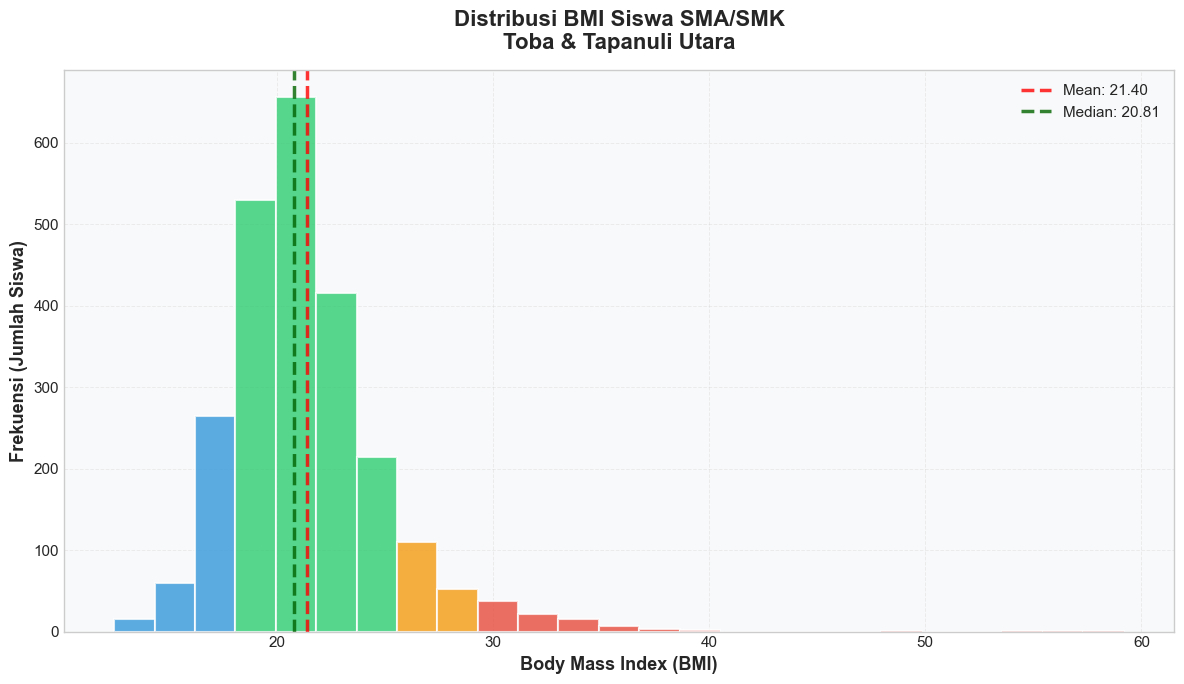

1. Distribusi BMI → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\01_distribusi_bmi.png

Distribusi Persentase Kategori BMI:
   • Normal: 56.72% (1364 siswa)
   • Kurus: 18.46% (444 siswa)
   • Overweight: 12.10% (291 siswa)
   • Obesitas I: 9.81% (236 siswa)
   • Obesitas II: 2.74% (66 siswa)
   • Obesitas Morbid: 0.17% (4 siswa)


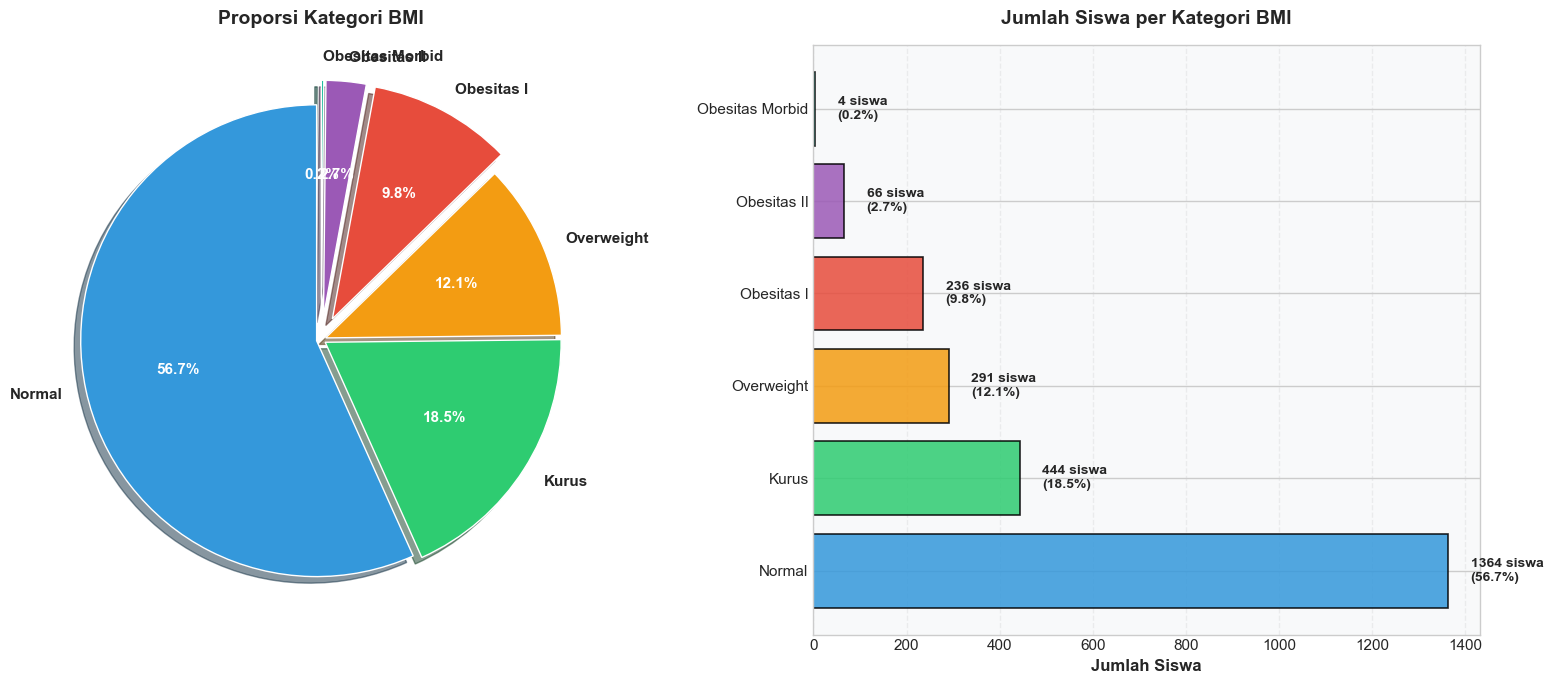

2. Proporsi Kategori BMI → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\02_proporsi_kategori_bmi.png


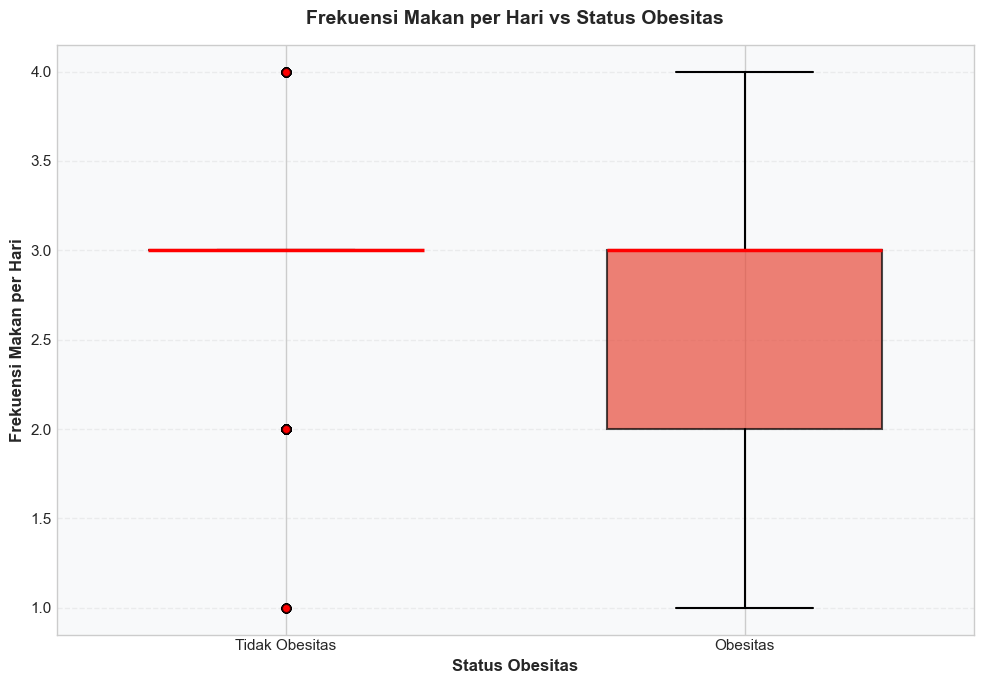

3. Makan per Hari vs Obesitas → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\03_makan_per_hari_vs_obesitas.png


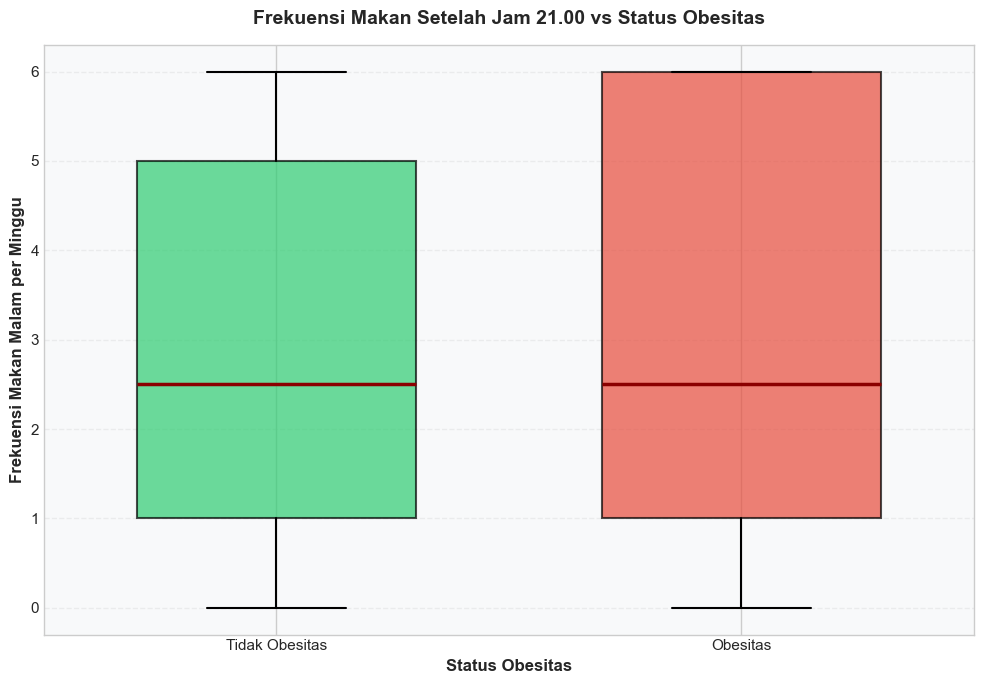

4. Makan Setelah Jam 21.00 vs Obesitas → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\04_makan_setelah_21_vs_obesitas.png


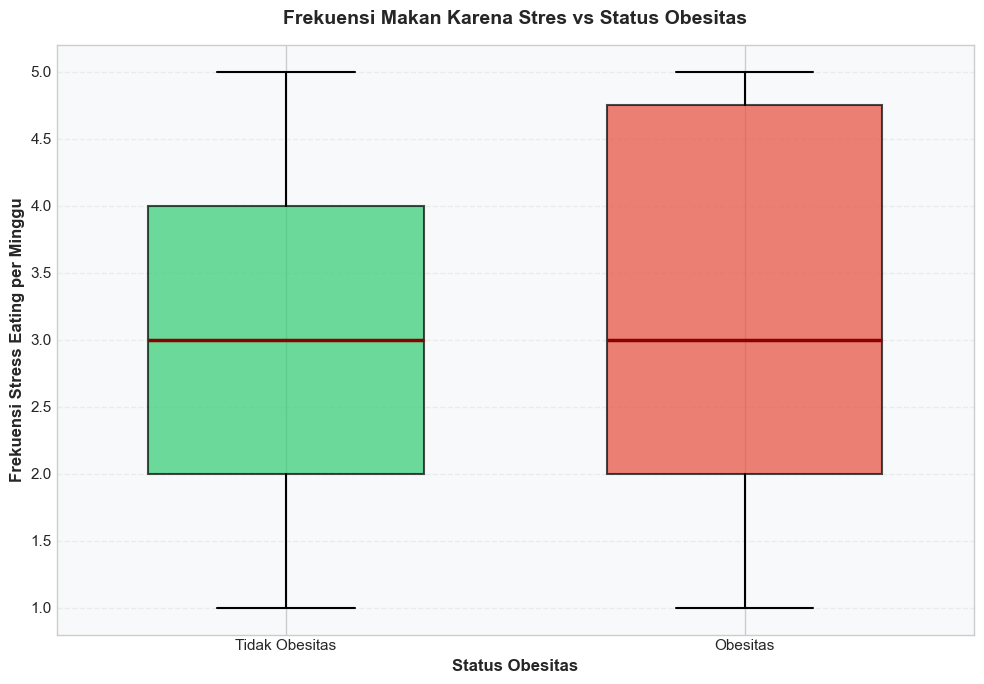

5. Makan Karena Stres vs Obesitas → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\05_makan_karena_stres_vs_obesitas.png


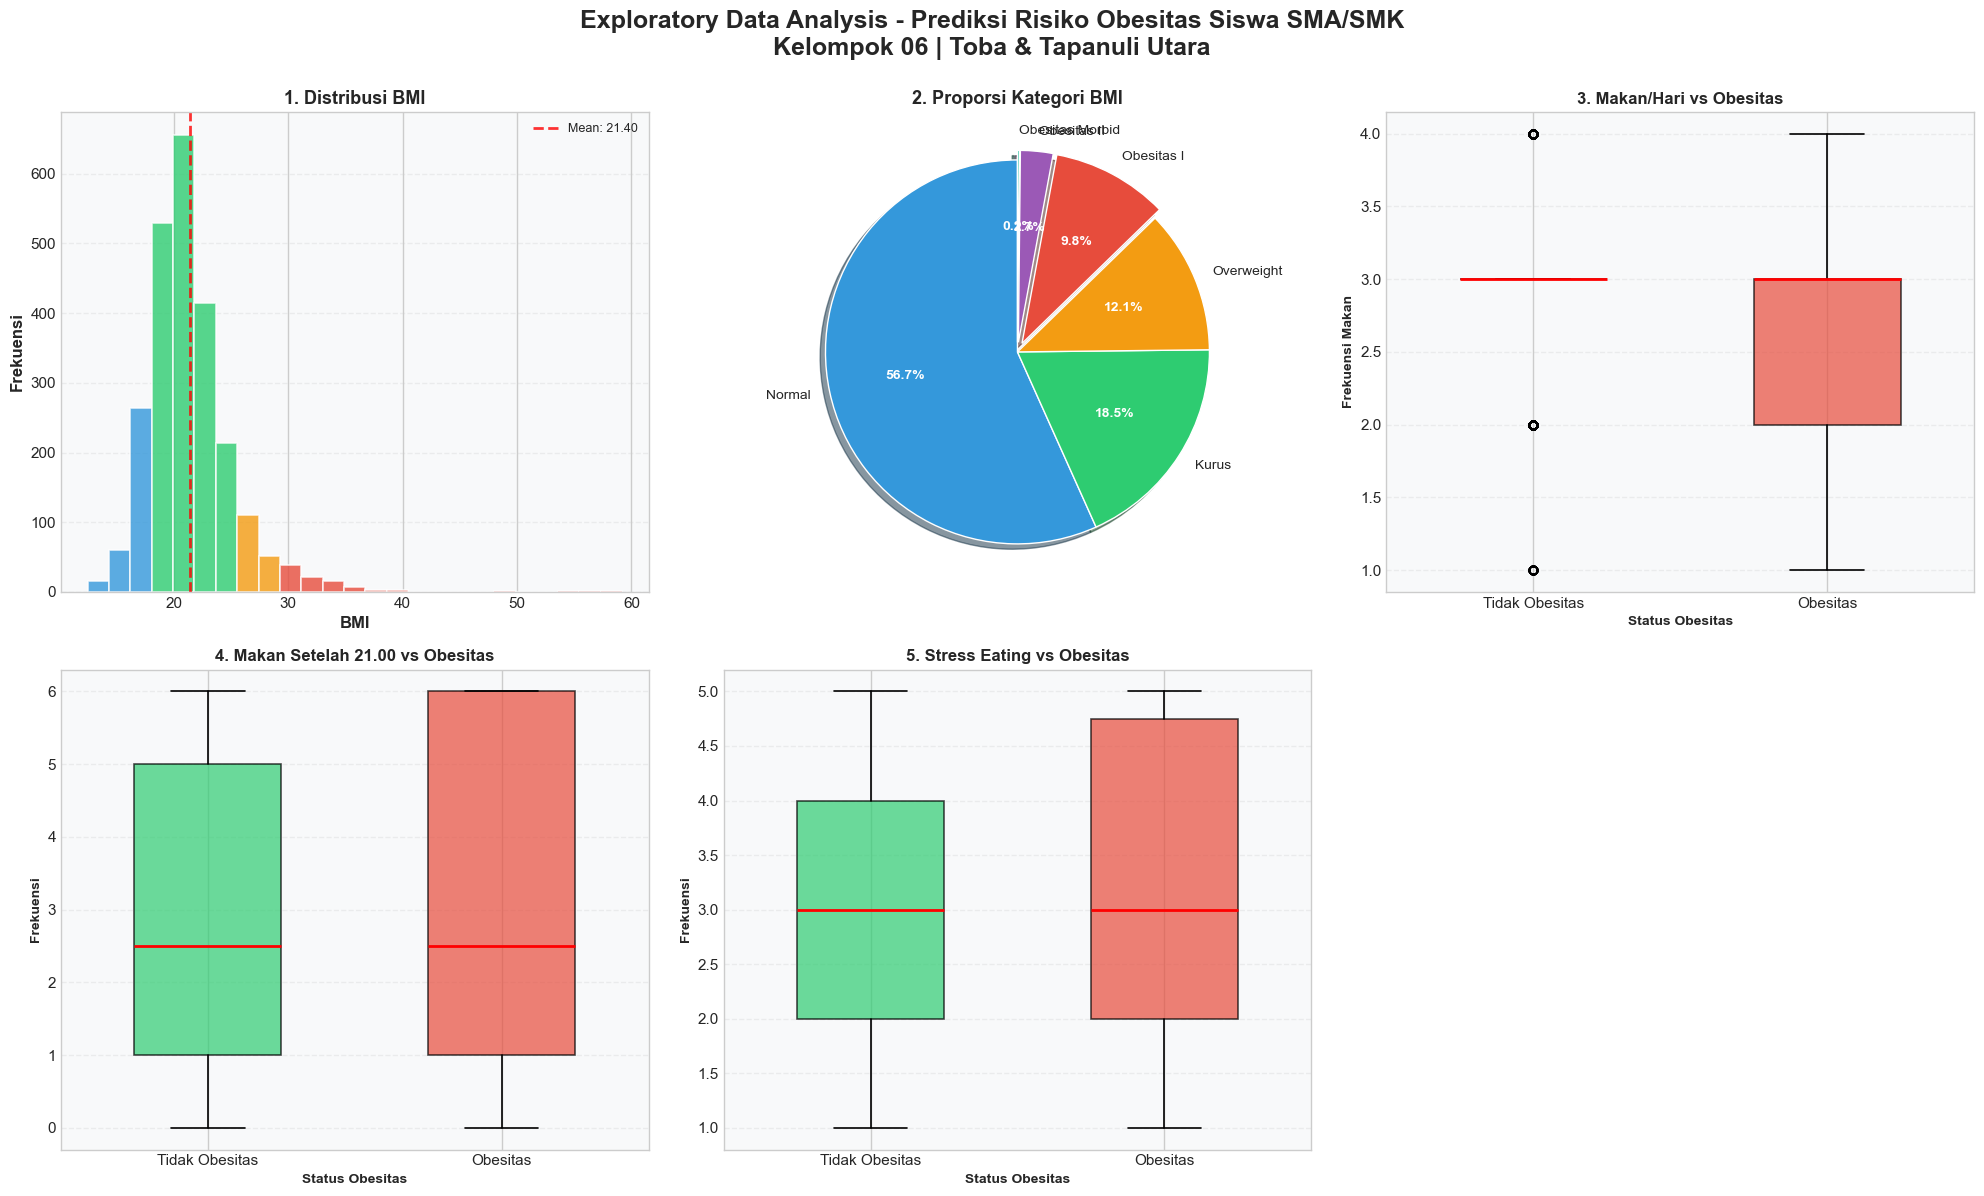

6. EDA Overview Gabungan → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\06_eda_overview_gabungan.png

RINGKASAN VISUALISASI
Total visualisasi dibuat: 6
Lokasi: C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations

Daftar file:
   1. 01_distribusi_bmi.png                         (  167.56 KB)
   2. 02_proporsi_kategori_bmi.png                  (  412.09 KB)
   3. 03_makan_per_hari_vs_obesitas.png             (  115.21 KB)
   4. 04_makan_setelah_21_vs_obesitas.png           (  121.93 KB)
   5. 05_makan_karena_stres_vs_obesitas.png         (  132.56 KB)
   6. 06_eda_overview_gabungan.png                  (  566.94 KB)

Total ukuran: 1516.29 KB (1.48 MB)
Semua visualisasi berhasil dibuat!


In [38]:
# ==========================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Setup styling yang lebih bagus
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Setup path untuk visualizations
VIZ_DIR = r"C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations"
os.makedirs(VIZ_DIR, exist_ok=True)

print("\n" + "="*70)
print("TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)
print(f"Folder visualisasi: {VIZ_DIR}\n")

# Kolom untuk Statistik Deskriptif
print("STATISTIK DESKRIPTIF:")
desc_cols = ['usia_tahun', 'berat_kg', 'tinggi_cm', 'BMI', 'makan_per_hari',
             'jajan_per_minggu', 'minuman_manis_per_minggu', 'durasi_tidur_jam',
             'makan_setelah_21', 'aktivitas_fisik', 'makan_karena_stres']
available_desc_cols = [c for c in desc_cols if c in df.columns]
print(df[available_desc_cols].describe().round(2))

# Counter untuk file
viz_counter = 1

# ============================================================
# VISUALISASI 1: Distribusi BMI (Histogram) - IMPROVED
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Histogram dengan styling lebih bagus
n, bins, patches = ax.hist(df["BMI"], bins=25, color='#3498db', 
                           edgecolor='white', alpha=0.8, linewidth=1.5)

# Gradient color untuk bars (dari biru ke merah sesuai BMI)
cm = plt.cm.RdYlGn_r
for i, patch in enumerate(patches):
    bmi_value = (bins[i] + bins[i+1]) / 2
    if bmi_value < 18.5:
        color = '#3498db'  # Biru untuk underweight
    elif bmi_value < 25:
        color = '#2ecc71'  # Hijau untuk normal
    elif bmi_value < 30:
        color = '#f39c12'  # Orange untuk overweight
    else:
        color = '#e74c3c'  # Merah untuk obesitas
    patch.set_facecolor(color)

# Statistik
mean_bmi = df["BMI"].mean()
median_bmi = df["BMI"].median()

# Garis vertikal dengan styling lebih baik
ax.axvline(mean_bmi, color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {mean_bmi:.2f}', alpha=0.8)
ax.axvline(median_bmi, color='darkgreen', linestyle='--', linewidth=2.5, 
           label=f'Median: {median_bmi:.2f}', alpha=0.8)

# Labels
ax.set_title("Distribusi BMI Siswa SMA/SMK\nToba & Tapanuli Utara", 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Body Mass Index (BMI)", fontsize=13, fontweight='bold')
ax.set_ylabel("Frekuensi (Jumlah Siswa)", fontsize=13, fontweight='bold')

# Legend dengan styling
ax.legend(loc='upper right', fontsize=11, framealpha=0.95, 
          shadow=True, fancybox=True)

# Grid yang lebih halus
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_distribusi_bmi.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"{viz_counter}. Distribusi BMI → {output_path}")
viz_counter += 1

# ============================================================
# VISUALISASI 2: Proporsi Kategori BMI (Pie Chart) - IMPROVED
# ============================================================
bmi_percentage_distribution = df['kategori_BMI'].value_counts(normalize=True) * 100
print("\nDistribusi Persentase Kategori BMI:")
for cat, pct in bmi_percentage_distribution.items():
    count = df['kategori_BMI'].value_counts()[cat]
    print(f"   • {cat}: {pct:.2f}% ({count} siswa)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

bmi_counts = df["kategori_BMI"].value_counts()

# Colors yang lebih professional
colors_professional = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c']

# Explode kategori Obesitas
explode = [0.1 if 'Obesitas' in label else 0.02 for label in bmi_counts.index]

# PIE CHART (Kiri)
wedges, texts, autotexts = ax1.pie(bmi_counts, labels=bmi_counts.index, 
                                     autopct='%1.1f%%',
                                     startangle=90, 
                                     colors=colors_professional[:len(bmi_counts)], 
                                     explode=explode, 
                                     shadow=True,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})

# Styling untuk percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax1.set_title("Proporsi Kategori BMI", fontsize=14, fontweight='bold', pad=15)

# BAR CHART (Kanan) untuk perbandingan
bars = ax2.barh(bmi_counts.index, bmi_counts.values, 
                color=colors_professional[:len(bmi_counts)], 
                alpha=0.85, edgecolor='black', linewidth=1.2)

# Tambahkan nilai di ujung bar
for i, (cat, count) in enumerate(zip(bmi_counts.index, bmi_counts.values)):
    pct = bmi_percentage_distribution[cat]
    ax2.text(count + len(df)*0.02, i, f'{count} siswa\n({pct:.1f}%)', 
             va='center', fontsize=10, fontweight='bold')

ax2.set_xlabel("Jumlah Siswa", fontsize=12, fontweight='bold')
ax2.set_title("Jumlah Siswa per Kategori BMI", fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

plt.tight_layout()
output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_proporsi_kategori_bmi.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"{viz_counter}. Proporsi Kategori BMI → {output_path}")
viz_counter += 1

# ============================================================
# VISUALISASI 3: Makan per Hari vs Obesitas - IMPROVED
# ============================================================
if 'makan_per_hari' in df.columns and 'label_obesitas' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Data untuk boxplot
    data_to_plot = [df[df['label_obesitas']==0]['makan_per_hari'].dropna(),
                    df[df['label_obesitas']==1]['makan_per_hari'].dropna()]
    
    # Boxplot dengan styling
    bp = ax.boxplot(data_to_plot, labels=['Tidak Obesitas', 'Obesitas'],
                    patch_artist=True, widths=0.6,
                    boxprops=dict(facecolor='#3498db', alpha=0.7, linewidth=1.5),
                    medianprops=dict(color='red', linewidth=2.5),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', 
                                   markersize=6, alpha=0.5))
    
    # Warna berbeda untuk setiap box
    colors = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Labels
    ax.set_title("Frekuensi Makan per Hari vs Status Obesitas", 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Status Obesitas", fontsize=12, fontweight='bold')
    ax.set_ylabel("Frekuensi Makan per Hari", fontsize=12, fontweight='bold')
    
    # Grid dan background
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_makan_per_hari_vs_obesitas.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"{viz_counter}. Makan per Hari vs Obesitas → {output_path}")
    viz_counter += 1

# ============================================================
# VISUALISASI 4: Makan Setelah Jam 21.00 vs Obesitas - IMPROVED
# ============================================================
if 'makan_setelah_21' in df.columns and 'label_obesitas' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    data_to_plot = [df[df['label_obesitas']==0]['makan_setelah_21'].dropna(),
                    df[df['label_obesitas']==1]['makan_setelah_21'].dropna()]
    
    bp = ax.boxplot(data_to_plot, labels=['Tidak Obesitas', 'Obesitas'],
                    patch_artist=True, widths=0.6,
                    boxprops=dict(facecolor='#f39c12', alpha=0.7, linewidth=1.5),
                    medianprops=dict(color='darkred', linewidth=2.5),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', 
                                   markersize=6, alpha=0.5))
    
    colors = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title("Frekuensi Makan Setelah Jam 21.00 vs Status Obesitas", 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Status Obesitas", fontsize=12, fontweight='bold')
    ax.set_ylabel("Frekuensi Makan Malam per Minggu", fontsize=12, fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_makan_setelah_21_vs_obesitas.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"{viz_counter}. Makan Setelah Jam 21.00 vs Obesitas → {output_path}")
    viz_counter += 1

# ============================================================
# VISUALISASI 5: Makan Karena Stres vs Obesitas - IMPROVED
# ============================================================
if 'makan_karena_stres' in df.columns and 'label_obesitas' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    data_to_plot = [df[df['label_obesitas']==0]['makan_karena_stres'].dropna(),
                    df[df['label_obesitas']==1]['makan_karena_stres'].dropna()]
    
    bp = ax.boxplot(data_to_plot, labels=['Tidak Obesitas', 'Obesitas'],
                    patch_artist=True, widths=0.6,
                    boxprops=dict(facecolor='#9b59b6', alpha=0.7, linewidth=1.5),
                    medianprops=dict(color='darkred', linewidth=2.5),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', 
                                   markersize=6, alpha=0.5))
    
    colors = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title("Frekuensi Makan Karena Stres vs Status Obesitas", 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Status Obesitas", fontsize=12, fontweight='bold')
    ax.set_ylabel("Frekuensi Stress Eating per Minggu", fontsize=12, fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_makan_karena_stres_vs_obesitas.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"{viz_counter}. Makan Karena Stres vs Obesitas → {output_path}")
    viz_counter += 1

# ============================================================
# VISUALISASI 6: EDA Overview Gabungan - IMPROVED
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Exploratory Data Analysis - Prediksi Risiko Obesitas Siswa SMA/SMK\nKelompok 06 | Toba & Tapanuli Utara", 
             fontsize=18, fontweight='bold', y=0.995)
axes = axes.flatten()
plot_index = 0

# 1. Histogram BMI
n, bins, patches = axes[plot_index].hist(df["BMI"], bins=25, color='#3498db', 
                                         edgecolor='white', alpha=0.8, linewidth=1.2)
for i, patch in enumerate(patches):
    bmi_value = (bins[i] + bins[i+1]) / 2
    if bmi_value < 18.5:
        color = '#3498db'
    elif bmi_value < 25:
        color = '#2ecc71'
    elif bmi_value < 30:
        color = '#f39c12'
    else:
        color = '#e74c3c'
    patch.set_facecolor(color)

axes[plot_index].axvline(df["BMI"].mean(), color='red', linestyle='--', 
                         linewidth=2, label=f'Mean: {df["BMI"].mean():.2f}', alpha=0.8)
axes[plot_index].set_title("1. Distribusi BMI", fontweight='bold', fontsize=13)
axes[plot_index].set_xlabel("BMI", fontweight='bold')
axes[plot_index].set_ylabel("Frekuensi", fontweight='bold')
axes[plot_index].legend(fontsize=9)
axes[plot_index].grid(axis='y', alpha=0.3, linestyle='--')
axes[plot_index].set_facecolor('#f8f9fa')
plot_index += 1

# 2. Pie Chart
bmi_counts = df["kategori_BMI"].value_counts()
colors_pie = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c']
explode = [0.05 if 'Obesitas' in label else 0 for label in bmi_counts.index]

wedges, texts, autotexts = axes[plot_index].pie(bmi_counts, labels=bmi_counts.index, 
                                                  autopct='%1.1f%%', startangle=90,
                                                  colors=colors_pie[:len(bmi_counts)],
                                                  explode=explode, shadow=True,
                                                  textprops={'fontsize': 10})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[plot_index].set_title("2. Proporsi Kategori BMI", fontweight='bold', fontsize=13)
plot_index += 1

# 3-5. Boxplots dengan styling yang sama
boxplot_configs = [
    ('makan_per_hari', '3. Makan/Hari vs Obesitas', 'Frekuensi Makan'),
    ('makan_setelah_21', '4. Makan Setelah 21.00 vs Obesitas', 'Frekuensi'),
    ('makan_karena_stres', '5. Stress Eating vs Obesitas', 'Frekuensi')
]

for col, title, ylabel in boxplot_configs:
    if col in df.columns and 'label_obesitas' in df.columns:
        data_to_plot = [df[df['label_obesitas']==0][col].dropna(),
                       df[df['label_obesitas']==1][col].dropna()]
        
        bp = axes[plot_index].boxplot(data_to_plot, 
                                       labels=['Tidak Obesitas', 'Obesitas'],
                                       patch_artist=True, widths=0.5,
                                       boxprops=dict(alpha=0.7, linewidth=1.2),
                                       medianprops=dict(color='red', linewidth=2),
                                       whiskerprops=dict(linewidth=1.2),
                                       capprops=dict(linewidth=1.2))
        
        colors = ['#2ecc71', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        axes[plot_index].set_title(title, fontweight='bold', fontsize=12)
        axes[plot_index].set_xlabel("Status Obesitas", fontweight='bold', fontsize=10)
        axes[plot_index].set_ylabel(ylabel, fontweight='bold', fontsize=10)
        axes[plot_index].set_facecolor('#f8f9fa')
        axes[plot_index].grid(axis='y', alpha=0.3, linestyle='--')
        plot_index += 1

# Hapus slot kosong
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_eda_overview_gabungan.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"{viz_counter}. EDA Overview Gabungan → {output_path}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*70)
print("RINGKASAN VISUALISASI")
print("="*70)
print(f"Total visualisasi dibuat: {viz_counter}")
print(f"Lokasi: {VIZ_DIR}\n")
print("Daftar file:")

total_size = 0
for i, file in enumerate(sorted(os.listdir(VIZ_DIR)), 1):
    if file.endswith('.png'):
        file_path = os.path.join(VIZ_DIR, file)
        size_kb = os.path.getsize(file_path) / 1024
        total_size += size_kb
        print(f"   {i}. {file:<45} ({size_kb:>8.2f} KB)")

print(f"\nTotal ukuran: {total_size:.2f} KB ({total_size/1024:.2f} MB)")
print("="*70)
print("Semua visualisasi berhasil dibuat!")
print("="*70)

DISTRIBUSI LABEL OBESITAS
Tidak Obesitas (0): 2099 (87.28%)
Obesitas (1): 306 (12.72%)

📈 Membuat visualisasi 7: Distribusi BMI per Class...


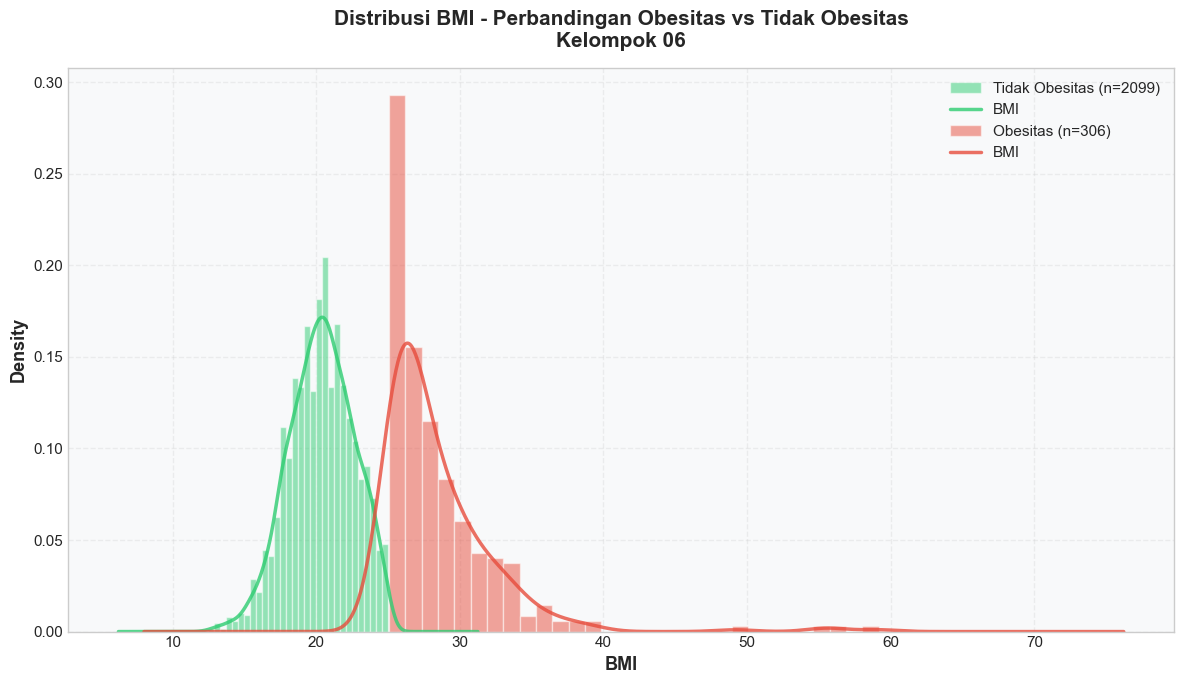

7. Distribusi BMI per Class → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\07_distribusi_bmi_per_class.png

🎻 Membuat visualisasi 8: Violin Plot fitur kunci...


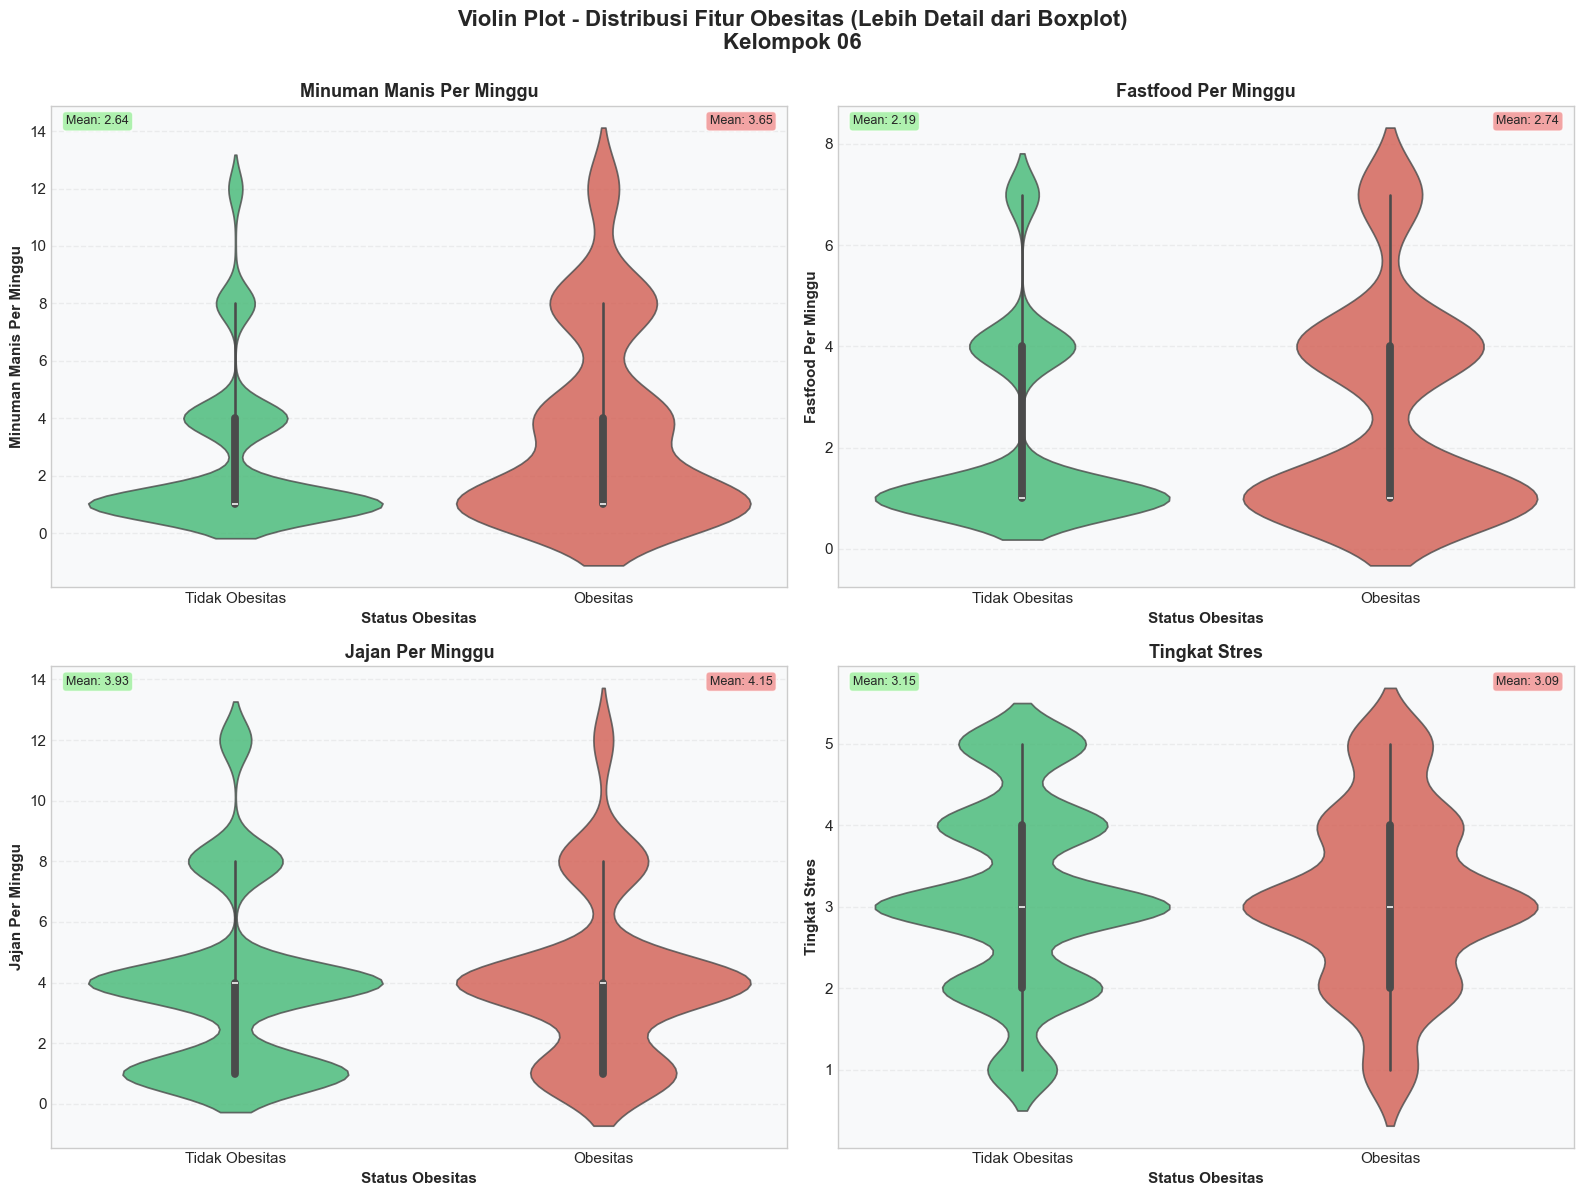

8. Violin Plot → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\08_violin_plot_fitur_kunci.png

Membuat visualisasi 9: Perbandingan Mean dengan Error Bars...


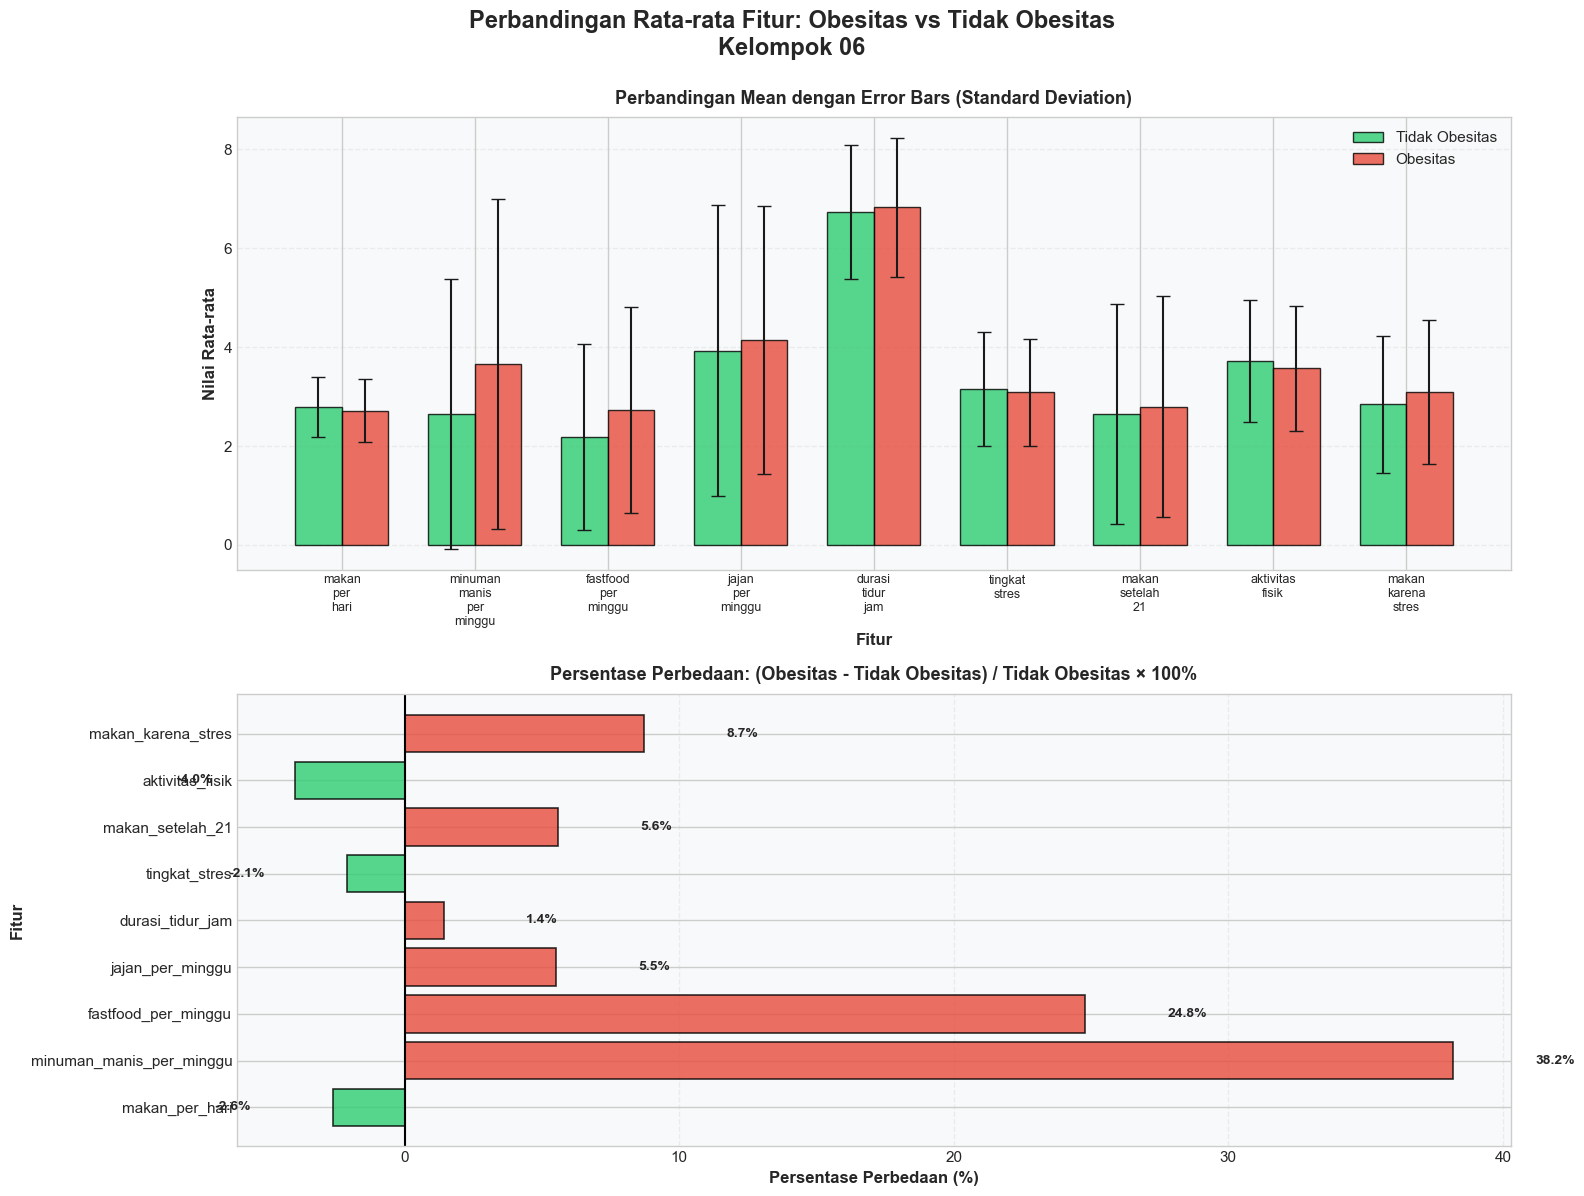

9. Perbandingan Mean → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\09_perbandingan_mean_errorbar.png


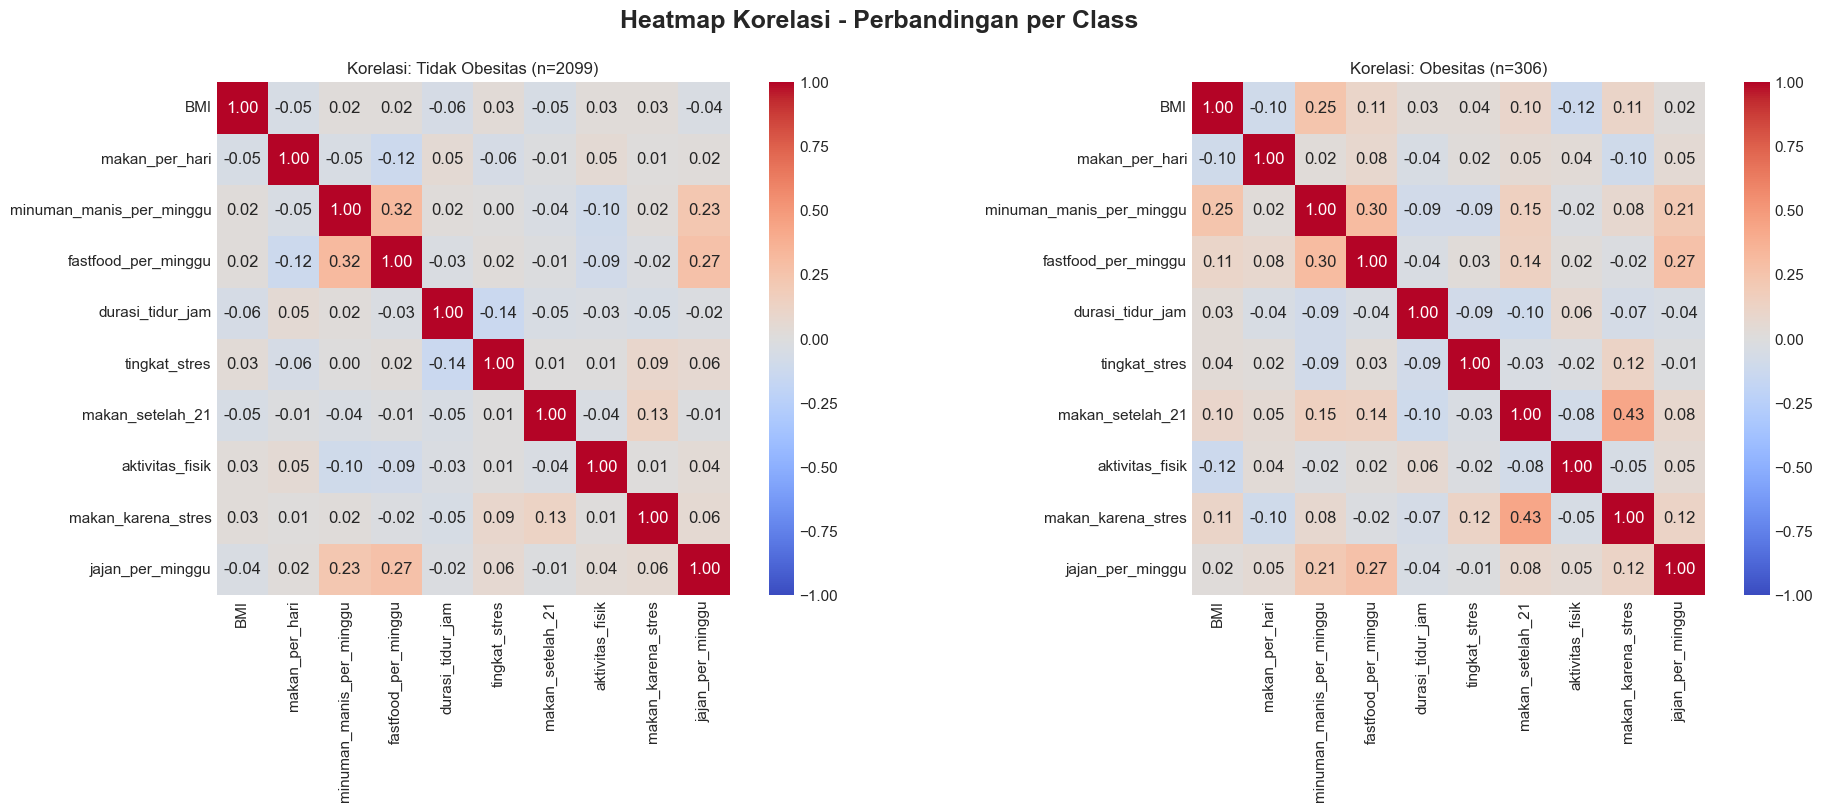

10. Heatmap Korelasi per Class → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\10_heatmap_korelasi_per_class.png

Membuat visualisasi 11: Proporsi Obesitas per Kategori...


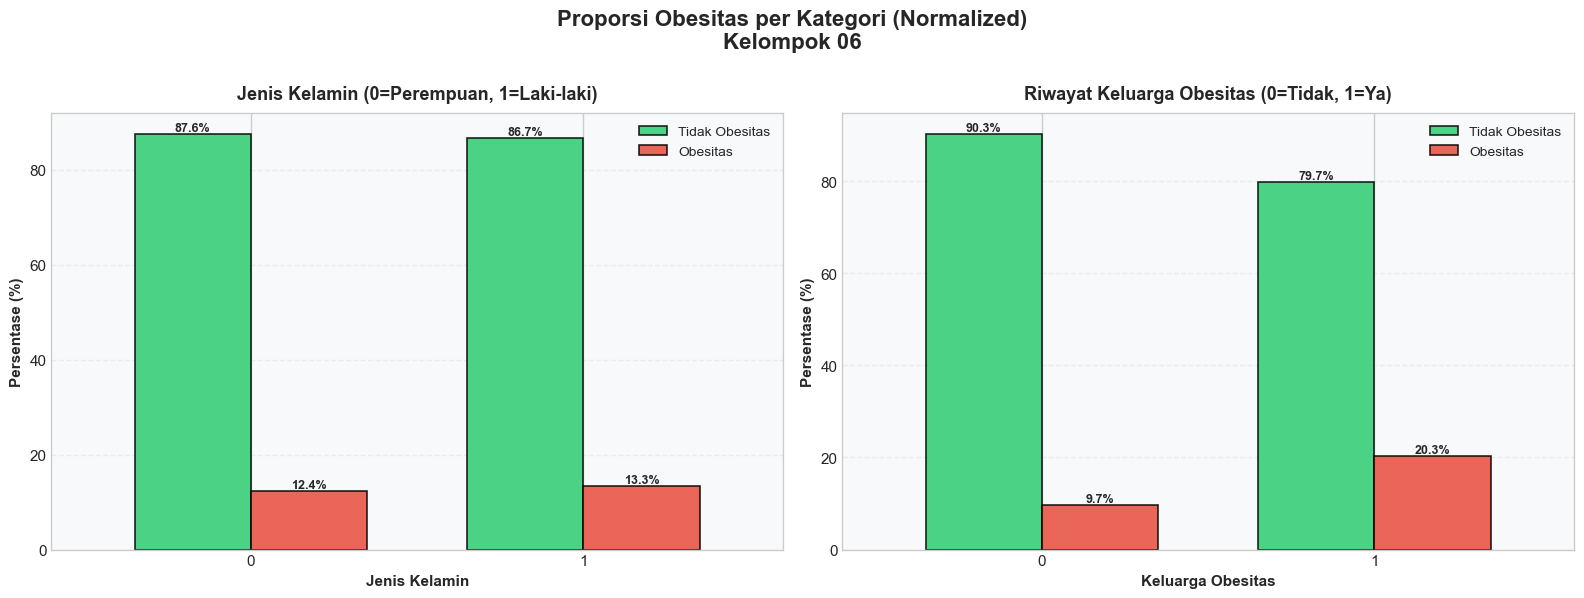

11. Proporsi per Kategori → C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\11_proporsi_obesitas_per_kategori.png

UJI STATISTIK: Independent T-Test (Obesitas vs Tidak Obesitas)
                   Fitur Mean_Tidak Mean_Ya  Diff p_value Cohen_d Sig
          Makan Per Hari       2.79    2.72 -0.07  0.0513   -0.12  ns
Minuman Manis Per Minggu       2.64    3.65  1.01  0.0000    0.33 ***
     Fastfood Per Minggu       2.19    2.74  0.54  0.0000    0.27 ***
        Jajan Per Minggu       3.93    4.15  0.22  0.2236    0.08  ns
        Durasi Tidur Jam       6.73    6.83  0.10  0.2512    0.07  ns
           Tingkat Stres       3.15    3.09 -0.07  0.3493   -0.06  ns
        Makan Setelah 21       2.65    2.80  0.15  0.2758    0.07  ns
         Aktivitas Fisik       3.72    3.57 -0.15  0.0514   -0.12  ns
      Makan Karena Stres       2.84    3.09  0.25  0.0036    0.17  **

Keterangan:
   *** p < 0.001 (Sangat Signifikan)
   **  p < 0.01  (Signifikan)
   *   p < 0.05  (Cukup Signifikan)

In [42]:
"""
EDA VISUALISASI TAMBAHAN
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Setup path
VIZ_DIR = r"C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations"
os.makedirs(VIZ_DIR, exist_ok=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Load data
df = pd.read_csv(r"C:\Users\ANISETUS B. MANALU\kelompok_06\data\dataset_bersih.csv")

print("=" * 80)
print("DISTRIBUSI LABEL OBESITAS")
print("=" * 80)
label_counts = df['label_obesitas'].value_counts()
label_props = df['label_obesitas'].value_counts(normalize=True) * 100
print(f"Tidak Obesitas (0): {label_counts[0]} ({label_props[0]:.2f}%)")
print(f"Obesitas (1): {label_counts[1]} ({label_props[1]:.2f}%)")
print("=" * 80)

viz_counter = 7  # Lanjut dari visualisasi sebelumnya (1-6)

# ============================================================================
# VISUALISASI 7: Distribusi BMI per Class (Histogram + KDE)
# ============================================================================
print("\n📈 Membuat visualisasi 7: Distribusi BMI per Class...")
fig, ax = plt.subplots(figsize=(12, 7))

# Plot untuk setiap class
colors = ['#2ecc71', '#e74c3c']
labels_text = ['Tidak Obesitas', 'Obesitas']

for label, color, text in zip([0, 1], colors, labels_text):
    subset = df[df['label_obesitas'] == label]['BMI']
    
    # Histogram
    ax.hist(subset, bins=30, alpha=0.5, color=color, 
            label=f'{text} (n={len(subset)})', density=True, edgecolor='white')
    
    # KDE line
    subset.plot.kde(ax=ax, linewidth=2.5, color=color, alpha=0.8)

ax.set_xlabel('BMI', fontsize=13, fontweight='bold')
ax.set_ylabel('Density', fontsize=13, fontweight='bold')
ax.set_title('Distribusi BMI - Perbandingan Obesitas vs Tidak Obesitas\nKelompok 06', 
             fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9, shadow=True)
ax.grid(alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_distribusi_bmi_per_class.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"{viz_counter}. Distribusi BMI per Class → {output_path}")
viz_counter += 1

# ============================================================================
# VISUALISASI 8: Violin Plot - Fitur Kunci (LEBIH INFORMATIF dari boxplot)
# ============================================================================
print("\n🎻 Membuat visualisasi 8: Violin Plot fitur kunci...")
violin_cols = [
    'minuman_manis_per_minggu', 'fastfood_per_minggu',
    'jajan_per_minggu', 'tingkat_stres'
]

available_violin = [c for c in violin_cols if c in df.columns]

if available_violin and 'label_obesitas' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Violin Plot - Distribusi Fitur Obesitas (Lebih Detail dari Boxplot)\nKelompok 06", 
                 fontsize=16, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    for i, col in enumerate(available_violin):
        sns.violinplot(data=df, x='label_obesitas', y=col, ax=axes[i], 
                      palette=['#2ecc71', '#e74c3c'], inner='box', alpha=0.8)
        
        axes[i].set_title(f"{col.replace('_', ' ').title()}", fontweight='bold', fontsize=13)
        axes[i].set_xlabel("Status Obesitas", fontweight='bold', fontsize=11)
        axes[i].set_ylabel(col.replace('_', ' ').title(), fontweight='bold', fontsize=11)
        axes[i].set_xticklabels(['Tidak Obesitas', 'Obesitas'])
        axes[i].grid(axis='y', alpha=0.3, linestyle='--')
        axes[i].set_facecolor('#f8f9fa')
        
        # Tambahkan mean value
        mean_0 = df[df['label_obesitas']==0][col].mean()
        mean_1 = df[df['label_obesitas']==1][col].mean()
        axes[i].text(0.02, 0.98, f'Mean: {mean_0:.2f}', transform=axes[i].transAxes, 
                    fontsize=9, verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        axes[i].text(0.98, 0.98, f'Mean: {mean_1:.2f}', transform=axes[i].transAxes, 
                    fontsize=9, verticalalignment='top', ha='right',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    
    plt.tight_layout()
    output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_violin_plot_fitur_kunci.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"{viz_counter}. Violin Plot → {output_path}")
    viz_counter += 1

# ============================================================================
# VISUALISASI 9: Perbandingan Mean dengan Error Bars
# ============================================================================
print("\nMembuat visualisasi 9: Perbandingan Mean dengan Error Bars...")
important_cols = [
    'makan_per_hari', 'minuman_manis_per_minggu', 'fastfood_per_minggu',
    'jajan_per_minggu', 'durasi_tidur_jam', 'tingkat_stres',
    'makan_setelah_21', 'aktivitas_fisik', 'makan_karena_stres'
]

available_important = [c for c in important_cols if c in df.columns]

if available_important and 'label_obesitas' in df.columns:
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    fig.suptitle("Perbandingan Rata-rata Fitur: Obesitas vs Tidak Obesitas\nKelompok 06", 
                 fontsize=17, fontweight='bold', y=0.995)
    
    # Calculate statistics
    means_0 = df[df['label_obesitas']==0][available_important].mean()
    means_1 = df[df['label_obesitas']==1][available_important].mean()
    std_0 = df[df['label_obesitas']==0][available_important].std()
    std_1 = df[df['label_obesitas']==1][available_important].std()
    
    # Mean comparison (TOP)
    ax1 = axes[0]
    x = np.arange(len(available_important))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, means_0, width, label='Tidak Obesitas', 
                    color='#2ecc71', yerr=std_0, capsize=5, alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, means_1, width, label='Obesitas', 
                    color='#e74c3c', yerr=std_1, capsize=5, alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Fitur', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Nilai Rata-rata', fontsize=12, fontweight='bold')
    ax1.set_title('Perbandingan Mean dengan Error Bars (Standard Deviation)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(x)
    ax1.set_xticklabels([c.replace('_', '\n') for c in available_important], 
                        rotation=0, ha='center', fontsize=9)
    ax1.legend(fontsize=11, loc='upper right', framealpha=0.9, shadow=True)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_facecolor('#f8f9fa')
    
    # Percentage difference (BOTTOM)
    ax2 = axes[1]
    pct_diff = ((means_1 - means_0) / means_0 * 100).fillna(0)
    colors_diff = ['#e74c3c' if x > 0 else '#2ecc71' for x in pct_diff]
    
    bars = ax2.barh(available_important, pct_diff, color=colors_diff, alpha=0.8, 
                    edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Persentase Perbedaan (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Fitur', fontsize=12, fontweight='bold')
    ax2.set_title('Persentase Perbedaan: (Obesitas - Tidak Obesitas) / Tidak Obesitas × 100%', 
                  fontsize=13, fontweight='bold', pad=10)
    ax2.axvline(0, color='black', linewidth=1.5)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_facecolor('#f8f9fa')
    
    # Add value labels
    for i, v in enumerate(pct_diff):
        ax2.text(v + (3 if v > 0 else -3), i, f'{v:.1f}%', 
                va='center', ha='left' if v > 0 else 'right', 
                fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_perbandingan_mean_errorbar.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"{viz_counter}. Perbandingan Mean → {output_path}")
    viz_counter += 1

# ============================================================================
# VISUALISASI 10: Heatmap Korelasi - Split by Class
# ============================================================================
# ============================================================================
# 6. HEATMAP KORELASI - SPLIT BY CLASS
# ============================================================================
corr_cols = [
    'BMI', 'makan_per_hari', 'minuman_manis_per_minggu',
    'fastfood_per_minggu', 'durasi_tidur_jam', 'tingkat_stres',
    'makan_setelah_21', 'aktivitas_fisik', 'makan_karena_stres',
    'jajan_per_minggu'
]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Heatmap Korelasi - Perbandingan per Class", fontsize=18, fontweight='bold')

# Tidak Obesitas
df_0 = df[df['label_obesitas']==0][corr_cols]
corr_0 = df_0.corr()
sns.heatmap(corr_0, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], 
            vmin=-1, vmax=1, center=0, square=True)
axes[0].set_title("Korelasi: Tidak Obesitas (n={})".format(len(df_0)))

# Obesitas
df_1 = df[df['label_obesitas']==1][corr_cols]
corr_1 = df_1.corr()
sns.heatmap(corr_1, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], 
            vmin=-1, vmax=1, center=0, square=True)
axes[1].set_title("Korelasi: Obesitas (n={})".format(len(df_1)))

plt.tight_layout(rect=[0,0,1,0.97])
output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_heatmap_korelasi_per_class.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"{viz_counter}. Heatmap Korelasi per Class → {output_path}")
viz_counter += 1

# ============================================================================
# VISUALISASI 11: Proporsi Obesitas per Kategori (Countplot Normalized)
# ============================================================================
print("\nMembuat visualisasi 11: Proporsi Obesitas per Kategori...")
cat_cols = ['jenis_kelamin', 'keluarga_obesitas']
available_cat = [c for c in cat_cols if c in df.columns]

if available_cat and 'label_obesitas' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Proporsi Obesitas per Kategori (Normalized)\nKelompok 06", 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for i, col in enumerate(available_cat):
        ax = axes[i]
        
        # Calculate proportions
        crosstab = pd.crosstab(df[col], df['label_obesitas'], normalize='index') * 100
        
        # Plot
        crosstab.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], 
                     width=0.7, edgecolor='black', linewidth=1.2, alpha=0.85)
        
        # Labels
        title_map = {
            'jenis_kelamin': 'Jenis Kelamin (0=Perempuan, 1=Laki-laki)',
            'keluarga_obesitas': 'Riwayat Keluarga Obesitas (0=Tidak, 1=Ya)'
        }
        ax.set_title(title_map.get(col, col.replace('_', ' ').title()), 
                    fontweight='bold', fontsize=13, pad=10)
        ax.set_xlabel(col.replace('_', ' ').title(), fontweight='bold', fontsize=11)
        ax.set_ylabel('Persentase (%)', fontweight='bold', fontsize=11)
        ax.legend(['Tidak Obesitas', 'Obesitas'], loc='upper right', 
                 fontsize=10, framealpha=0.9, shadow=True)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_facecolor('#f8f9fa')
        
        # Add value labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    output_path = os.path.join(VIZ_DIR, f"{viz_counter:02d}_proporsi_obesitas_per_kategori.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"{viz_counter}. Proporsi per Kategori → {output_path}")
    viz_counter += 1

# ============================================================================
# STATISTICAL TESTS - T-TEST (Print ke console, tidak visualisasi)
# ============================================================================
print("\n" + "=" * 80)
print("UJI STATISTIK: Independent T-Test (Obesitas vs Tidak Obesitas)")
print("=" * 80)

test_cols = [c for c in important_cols if c in df.columns]

if test_cols and 'label_obesitas' in df.columns:
    results = []
    for col in test_cols:
        group_0 = df[df['label_obesitas']==0][col].dropna()
        group_1 = df[df['label_obesitas']==1][col].dropna()
        
        if len(group_0) > 1 and len(group_1) > 1:
            # T-test
            t_stat, p_value = stats.ttest_ind(group_0, group_1)
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((group_0.std()**2 + group_1.std()**2) / 2)
            cohens_d = (group_1.mean() - group_0.mean()) / pooled_std if pooled_std > 0 else 0
            
            # Significance
            if p_value < 0.001:
                sig = "***"
            elif p_value < 0.01:
                sig = "**"
            elif p_value < 0.05:
                sig = "*"
            else:
                sig = "ns"
            
            results.append({
                'Fitur': col.replace('_', ' ').title(),
                'Mean_Tidak': f"{group_0.mean():.2f}",
                'Mean_Ya': f"{group_1.mean():.2f}",
                'Diff': f"{group_1.mean() - group_0.mean():.2f}",
                'p_value': f"{p_value:.4f}",
                'Cohen_d': f"{cohens_d:.2f}",
                'Sig': sig
            })
    
    if results:
        results_df = pd.DataFrame(results)
        print(results_df.to_string(index=False))
        print("\nKeterangan:")
        print("   *** p < 0.001 (Sangat Signifikan)")
        print("   **  p < 0.01  (Signifikan)")
        print("   *   p < 0.05  (Cukup Signifikan)")
        print("   ns  p >= 0.05 (Tidak Signifikan)")
        print("\nCohen's d interpretation:")
        print("   |d| < 0.2 = negligible, 0.2-0.5 = small, 0.5-0.8 = medium, >0.8 = large")

print("=" * 80)

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("RINGKASAN VISUALISASI")
print("=" * 80)
print(f"Total visualisasi baru dibuat: {viz_counter - 7}")
print(f"Lokasi: {VIZ_DIR}\n")
print("Daftar file baru:")

new_files = [f for f in os.listdir(VIZ_DIR) if f.endswith('.png') and int(f.split('_')[0]) >= 7]
total_size = 0

for i, file in enumerate(sorted(new_files), 1):
    file_path = os.path.join(VIZ_DIR, file)
    size_kb = os.path.getsize(file_path) / 1024
    total_size += size_kb
    print(f"   {i}. {file:<55} ({size_kb:>8.2f} KB)")

print(f"\nTotal ukuran file baru: {total_size:.2f} KB ({total_size/1024:.2f} MB)")
print("=" * 80)
print("SELESAI - Semua visualisasi penting berhasil dibuat!")
print("=" * 80)

In [43]:
# ==========================================
# 5. DATA PREPARATION UNTUK ML
# ==========================================
print("\n" + "="*70)
print("TAHAP 5: DATA PREPARATION UNTUK ML")
print("="*70)

# 5.1 Pilih fitur
features = [
    "usia_tahun",
    "jenis_kelamin",
    "makan_per_hari",
    "minuman_manis_per_minggu",
    "fastfood_per_minggu",
    "jajan_per_minggu",
    "aktivitas_fisik",
    "durasi_tidur_jam",
    "tingkat_stres",
    "pengaruh_teman",
    "keluarga_obesitas",
    "makan_setelah_21",
    "aktivitas_fisik",
    "makan_karena_stres",
    "video_makanan"
]

# Filter fitur yang ada di dataframe
available_features = [f for f in features if f in df.columns]
print(f"Fitur tersedia: {len(available_features)} dari {len(features)} features")
print(f"  Fitur yang digunakan: {available_features}")

missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"  Fitur tidak ditemukan: {missing_features}")

X = df[available_features]
y = df["label_obesitas"]

print(f"\nShape X: {X.shape}")
print(f"  Target distribution: {y.value_counts().to_dict()}")



TAHAP 5: DATA PREPARATION UNTUK ML
Fitur tersedia: 15 dari 15 features
  Fitur yang digunakan: ['usia_tahun', 'jenis_kelamin', 'makan_per_hari', 'minuman_manis_per_minggu', 'fastfood_per_minggu', 'jajan_per_minggu', 'aktivitas_fisik', 'durasi_tidur_jam', 'tingkat_stres', 'pengaruh_teman', 'keluarga_obesitas', 'makan_setelah_21', 'aktivitas_fisik', 'makan_karena_stres', 'video_makanan']

Shape X: (2405, 15)
  Target distribution: {0: 2099, 1: 306}


In [44]:

# 5.2 Train-test split dengan stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData split: train={X_train.shape[0]}, test={X_test.shape[0]}")

# 5.3 Imputasi SEBELUM scaling
imputer_ml = SimpleImputer(strategy='median')
X_train_imputed = imputer_ml.fit_transform(X_train)
X_test_imputed = imputer_ml.transform(X_test)
print("Missing values diimputasi dengan median")

# 5.4 Scaling dengan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print("Feature scaling dengan StandardScaler")

# 5.5 SMOTE untuk balance data
print("\nSMOTE - Synthetic Minority Over-sampling Technique:")
try:
    k_neighbors = min(5, y_train.sum()-1)
    if k_neighbors < 1:
        k_neighbors = 1
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)
    print(f"SMOTE applied:")
    print(f"  - Sebelum: Obesity={y_train.sum()}, Non-Obesity={len(y_train)-y_train.sum()}")
    print(f"  - Sesudah: Obesity={y_train_sm.sum()}, Non-Obesity={len(y_train_sm)-y_train_sm.sum()}")
    smote_applied = True
except Exception as e:
    print(f"SMOTE gagal: {e}")
    print("  Menggunakan data asli tanpa oversampling")
    X_train_sm, y_train_sm = X_train_scaled, y_train
    smote_applied = False




Data split: train=1924, test=481
Missing values diimputasi dengan median
Feature scaling dengan StandardScaler

SMOTE - Synthetic Minority Over-sampling Technique:
SMOTE applied:
  - Sebelum: Obesity=245, Non-Obesity=1679
  - Sesudah: Obesity=1679, Non-Obesity=1679


In [45]:
# ==========================================
# 6. MODELING - LOGISTIC REGRESSION
# ==========================================
print("\n" + "="*70)
print("TAHAP 6: MODELING - LOGISTIC REGRESSION")
print("="*70)

logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
logreg.fit(X_train_sm, y_train_sm)

y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression trained")
print(f"  Coefficients shape: {logreg.coef_.shape}")



TAHAP 6: MODELING - LOGISTIC REGRESSION
Logistic Regression trained
  Coefficients shape: (1, 15)


In [46]:
# ==========================================
# 7. MODELING - RANDOM FOREST
# ==========================================
print("\n" + "="*70)
print("TAHAP 7: MODELING - RANDOM FOREST")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5
)
rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("Random Forest trained")
print(f"  Number of trees: {rf.n_estimators}")



TAHAP 7: MODELING - RANDOM FOREST
Random Forest trained
  Number of trees: 100


In [47]:
# ==========================================
# 8. OPTIMAL THRESHOLD TUNING
# ==========================================
print("\n" + "="*70)
print("TAHAP 8: OPTIMAL THRESHOLD TUNING")
print("="*70)

def find_optimal_threshold(y_true, y_prob):
    """Cari threshold optimal menggunakan Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[best_idx]
    return optimal_threshold

threshold_lr = find_optimal_threshold(y_test, y_prob_logreg)
threshold_rf = find_optimal_threshold(y_test, y_prob_rf)

print(f"Optimal Threshold - Logistic Regression: {threshold_lr:.4f}")
print(f"Optimal Threshold - Random Forest: {threshold_rf:.4f}")

# Apply optimal threshold
y_pred_logreg_opt = (y_prob_logreg >= threshold_lr).astype(int)
y_pred_rf_opt = (y_prob_rf >= threshold_rf).astype(int)

print("\nOptimal threshold diterapkan")



TAHAP 8: OPTIMAL THRESHOLD TUNING
Optimal Threshold - Logistic Regression: 0.5396
Optimal Threshold - Random Forest: 0.3967

Optimal threshold diterapkan


In [48]:
# ==========================================
# 9. MODEL EVALUATION
# ==========================================
print("\n" + "="*70)
print("TAHAP 9: MODEL EVALUATION - DEFAULT vs OPTIMAL THRESHOLD")
print("="*70)

def evaluate_model(title, y_true, y_pred, y_prob):
    """Fungsi untuk evaluasi model"""
    print(f"\n{title}")
    print("-" * 60)
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    try:
        auc_val = roc_auc_score(y_true, y_prob)
        print(f"AUC-ROC:   {auc_val:.4f}")
    except:
        auc_val = 0
        print(f"AUC-ROC:   N/A (insufficient classes)")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Obesity', 'Obesity'], zero_division=0))
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, zero_division=0)

# Evaluasi dengan default threshold (0.5)
print("\nDEFAULT THRESHOLD (0.5):")
acc_lr_def, f1_lr_def = evaluate_model("LOGISTIC REGRESSION", y_test, y_pred_logreg, y_prob_logreg)
acc_rf_def, f1_rf_def = evaluate_model("RANDOM FOREST", y_test, y_pred_rf, y_prob_rf)

# Evaluasi dengan optimal threshold
print("\n\nOPTIMAL THRESHOLD:")
acc_lr_opt, f1_lr_opt = evaluate_model(f"LOGISTIC REGRESSION (Threshold={threshold_lr:.4f})", y_test, y_pred_logreg_opt, y_prob_logreg)
acc_rf_opt, f1_rf_opt = evaluate_model(f"RANDOM FOREST (Threshold={threshold_rf:.4f})", y_test, y_pred_rf_opt, y_prob_rf)



TAHAP 9: MODEL EVALUATION - DEFAULT vs OPTIMAL THRESHOLD

DEFAULT THRESHOLD (0.5):

LOGISTIC REGRESSION
------------------------------------------------------------
Accuracy:  0.6341
Precision: 0.2139
Recall:    0.7049
F1-Score:  0.3282
AUC-ROC:   0.7028

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.94      0.62      0.75       420
     Obesity       0.21      0.70      0.33        61

    accuracy                           0.63       481
   macro avg       0.57      0.66      0.54       481
weighted avg       0.84      0.63      0.70       481


RANDOM FOREST
------------------------------------------------------------
Accuracy:  0.8732
Precision: 0.5000
Recall:    0.1148
F1-Score:  0.1867
AUC-ROC:   0.6450

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.88      0.98      0.93       420
     Obesity       0.50      0.11      0.19        61

    accuracy                           


TAHAP 10: VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE


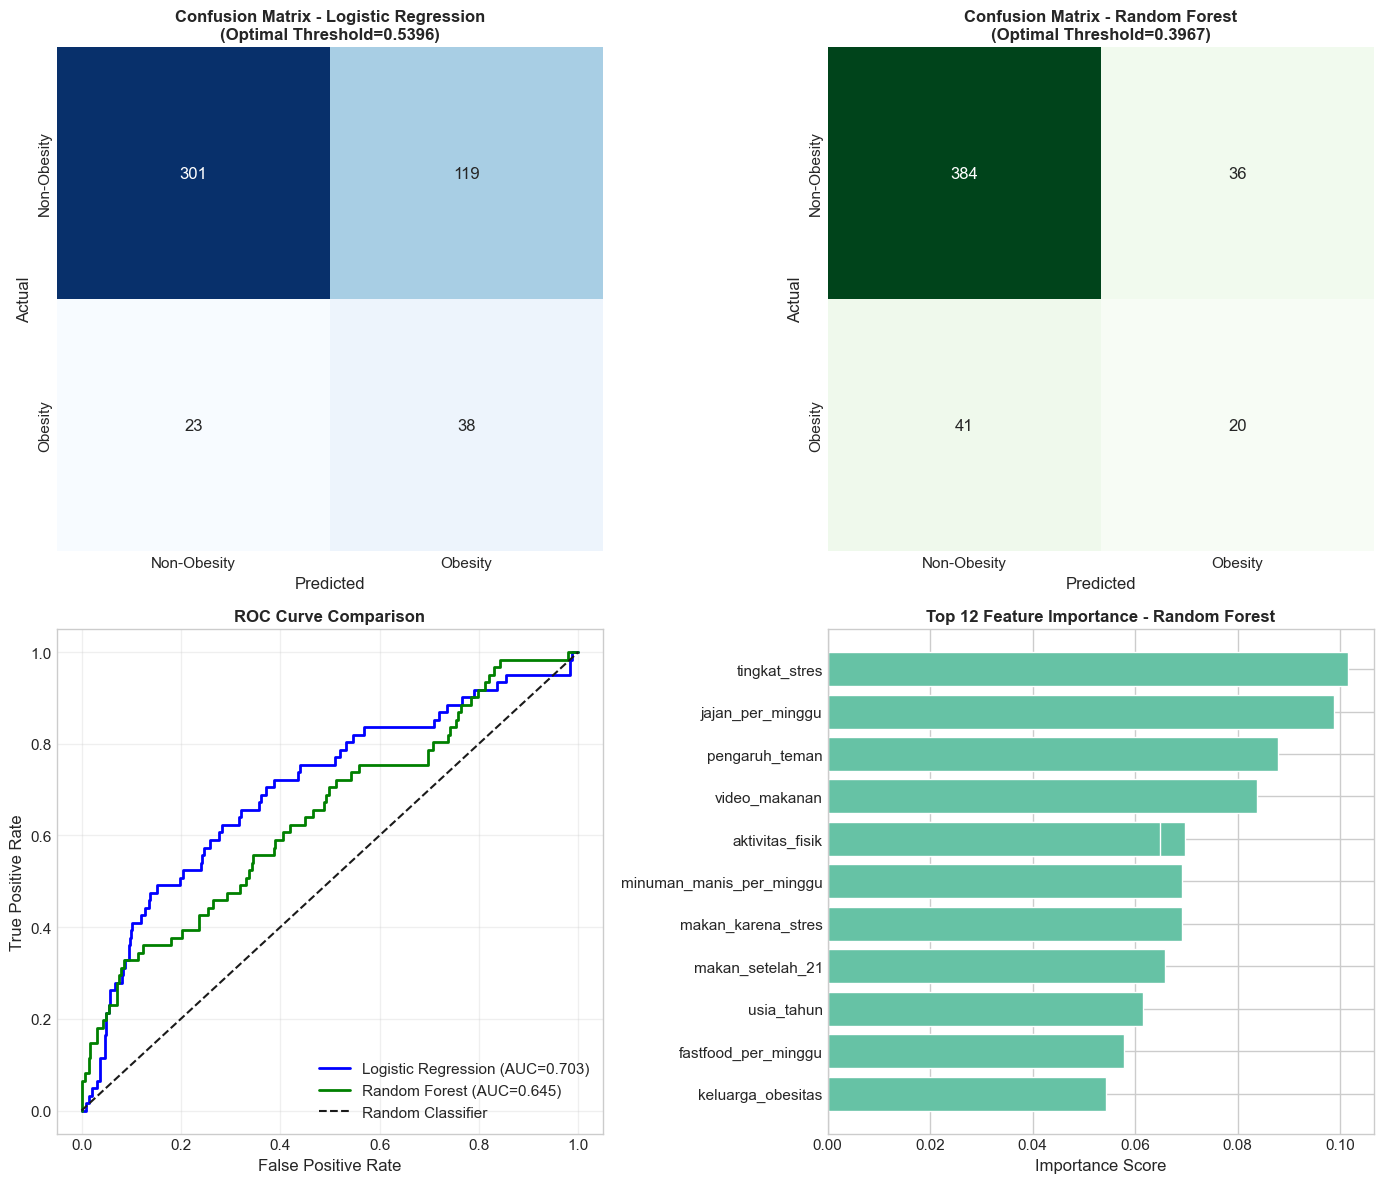


Selesai! Gambar evaluasi telah disimpan di:
C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations\model_evaluation.png


In [52]:
# ==========================================
# 10. VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE
# ==========================================
print("\n" + "="*70)
print("TAHAP 10: VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE")
print("="*70)

# --- SETTING PATH PENYIMPANAN ---
target_dir = r"C:\Users\ANISETUS B. MANALU\kelompok_06\visualizations"
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    print(f"Direktori dibuat: {target_dir}")

file_path = os.path.join(target_dir, "model_evaluation.png")
# --------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_logreg_opt)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=False)
axes[0, 0].set_title(f"Confusion Matrix - Logistic Regression\n(Optimal Threshold={threshold_lr:.4f})", fontweight='bold')
axes[0, 0].set_ylabel("Actual")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_xticklabels(['Non-Obesity', 'Obesity'])
axes[0, 0].set_yticklabels(['Non-Obesity', 'Obesity'])

# 2. Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_opt)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1], cbar=False)
axes[0, 1].set_title(f"Confusion Matrix - Random Forest\n(Optimal Threshold={threshold_rf:.4f})", fontweight='bold')
axes[0, 1].set_ylabel("Actual")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_xticklabels(['Non-Obesity', 'Obesity'])
axes[0, 1].set_yticklabels(['Non-Obesity', 'Obesity'])

# 3. ROC Curve
try:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    auc_lr = roc_auc_score(y_test, y_prob_logreg)
    auc_rf = roc_auc_score(y_test, y_prob_rf)

    axes[1, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2, color='blue')
    axes[1, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2, color='green')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 0].set_xlabel("False Positive Rate")
    axes[1, 0].set_ylabel("True Positive Rate")
    axes[1, 0].set_title("ROC Curve Comparison", fontweight='bold')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(alpha=0.3)
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f"ROC Curve unavailable\n{e}", ha='center', va='center')

# 4. Feature Importance - Random Forest
feat_importance = pd.Series(rf.feature_importances_, index=available_features).sort_values(ascending=False)
new_features = ['makan_setelah_21', 'aktivitas_fisik', 'makan_karena_stres']
colors = ['coral' if f in new_features else 'steelblue' for f in feat_importance.index[:12]]

axes[1, 1].barh(feat_importance.index[:12], feat_importance.values[:12])
axes[1, 1].set_xlabel("Importance Score")
axes[1, 1].set_title("Top 12 Feature Importance - Random Forest", fontweight='bold')
axes[1, 1].invert_yaxis()

# Final Touch & Save
plt.tight_layout()
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSelesai! Gambar evaluasi telah disimpan di:\n{file_path}")

In [53]:
# ==========================================
# 11. SAVE MODEL
# ==========================================
print("\n" + "="*70)
print("TAHAP 11: MENYIMPAN MODEL & ARTIFACTS")
print("="*70)

model_target_dir = r"C:\Users\ANISETUS B. MANALU\kelompok_06\models"

# Buat folder jika belum ada
if not os.path.exists(model_target_dir):
    os.makedirs(model_target_dir)
    print(f"Direktori baru dibuat: {model_target_dir}")

# Tentukan nama file lengkap
model_file_path = os.path.join(model_target_dir, "model_data.pkl")
# --------------------------------

# Menyiapkan dictionary berisi semua komponen model
model_data = {
    'logreg': logreg,
    'rf': rf,
    'scaler': scaler,
    'imputer': imputer_ml,
    'features': available_features,
    'threshold_lr': threshold_lr,
    'threshold_rf': threshold_rf,
    'feature_importance': feat_importance.to_dict(),
    'smote_applied': smote_applied
}

# Proses penyimpanan ke file .pkl
try:
    with open(model_file_path, "wb") as f:
        pickle.dump(model_data, f)
    
    print("Semua model dan artifacts berhasil disimpan!")
    print(f"Lokasi file: {model_file_path}")
    print("Artifacts yang tersimpan:")
    for key in model_data.keys():
        print(f"  - {key}")

except Exception as e:
    print(f"Terjadi kesalahan saat menyimpan model: {e}")



TAHAP 11: MENYIMPAN MODEL & ARTIFACTS
Semua model dan artifacts berhasil disimpan!
Lokasi file: C:\Users\ANISETUS B. MANALU\kelompok_06\models\model_data.pkl
Artifacts yang tersimpan:
  - logreg
  - rf
  - scaler
  - imputer
  - features
  - threshold_lr
  - threshold_rf
  - feature_importance
  - smote_applied


In [54]:
# ==========================================
# 12. KESIMPULAN & REKOMENDASI
# ==========================================
print("\n" + "="*70)
print("TAHAP 12: KESIMPULAN & REKOMENDASI")
print("="*70)

best_model = "Random Forest" if f1_rf_opt > f1_lr_opt else "Logistic Regression"
best_f1 = max(f1_rf_opt, f1_lr_opt)
best_auc = max(auc_lr, auc_rf) if 'auc_lr' in dir() and 'auc_rf' in dir() else 0

insights = f"""
SUMMARY ANALISIS OBESITAS SISWA (DENGAN 3 FITUR BARU):

1. DATA OVERVIEW:
   - Total siswa: {df.shape[0]}
   - Persentase obesitas (BMI >= 25): {df['label_obesitas'].mean()*100:.2f}%
   - Rata-rata BMI: {df['BMI'].mean():.2f}
   - Jumlah fitur: {len(available_features)}

2. KATEGORI BMI DISTRIBUTION (Standar Asia):
{df['kategori_BMI'].value_counts(normalize=True).mul(100).round(2)}

3. FAKTOR PALING BERPENGARUH (TOP 10):
{chr(10).join([f"   {i+1}. {feat}: {imp:.4f}" for i, (feat, imp) in enumerate(feat_importance.head(10).items())])}

4. BEST MODEL PERFORMANCE (Optimal Threshold):
   - Model: {best_model}
   - Accuracy: {max(acc_lr_opt, acc_rf_opt):.4f}
   - F1-Score: {best_f1:.4f}
   - AUC-ROC: {best_auc:.4f}
   - Threshold LR: {threshold_lr:.4f}
   - Threshold RF: {threshold_rf:.4f}

5. SMOTE Applied: {smote_applied}

6. REKOMENDASI KESEHATAN:
   a) Hindari makan setelah jam 21.00 (late-night eating)
   b) Tingkatkan aktivitas fisik harian (jalan kaki, naik turun tangga)
   c) Kelola stres dengan baik (hindari emotional eating)
   d) Kurangi konsumsi minuman manis (< 3 gelas/minggu)
   e) Tidur 7-8 jam setiap malam
   f) Batasi fast food (< 2 kali/minggu)
"""
print(insights)



TAHAP 12: KESIMPULAN & REKOMENDASI

SUMMARY ANALISIS OBESITAS SISWA (DENGAN 3 FITUR BARU):

1. DATA OVERVIEW:
   - Total siswa: 2405
   - Persentase obesitas (BMI >= 25): 12.72%
   - Rata-rata BMI: 21.40
   - Jumlah fitur: 15

2. KATEGORI BMI DISTRIBUTION (Standar Asia):
kategori_BMI
Normal             56.72
Kurus              18.46
Overweight         12.10
Obesitas I          9.81
Obesitas II         2.74
Obesitas Morbid     0.17
Name: proportion, dtype: float64

3. FAKTOR PALING BERPENGARUH (TOP 10):
   1. tingkat_stres: 0.1016
   2. jajan_per_minggu: 0.0989
   3. pengaruh_teman: 0.0879
   4. video_makanan: 0.0838
   5. aktivitas_fisik: 0.0698
   6. minuman_manis_per_minggu: 0.0692
   7. makan_karena_stres: 0.0692
   8. makan_setelah_21: 0.0658
   9. aktivitas_fisik: 0.0648
   10. usia_tahun: 0.0616

4. BEST MODEL PERFORMANCE (Optimal Threshold):
   - Model: Logistic Regression
   - Accuracy: 0.8399
   - F1-Score: 0.3486
   - AUC-ROC: 0.7028
   - Threshold LR: 0.5396
   - Threshold 

In [55]:

# ==========================================
# 13. TEST PREDIKSI REALTIME
# ==========================================
print("\n" + "="*70)
print("TEST PREDIKSI REALTIME - CONSISTENT MODELS")
print("="*70)

def predict_obesity(usia, jenis_kelamin, makan, minuman_manis, fastfood, jajan,
                   aktivitas, tidur, stres, teman, keluarga_obesitas,
                   makan_setelah_21=2, aktivitas_fisik_baru=3, makan_karena_stres=2,video_makanan=2):
    

    jk_encode = 1 if jenis_kelamin.lower() == "laki-laki" else 0
    keluarga_encode = 1 if keluarga_obesitas.lower() == "iya" else 0

    data_dict = {
        'usia_tahun': usia,
        'jenis_kelamin': jk_encode,
        'makan_per_hari': makan,
        'minuman_manis_per_minggu': minuman_manis,
        'fastfood_per_minggu': fastfood,
        'jajan_per_minggu': jajan,
        'aktivitas_fisik': aktivitas,
        'durasi_tidur_jam': tidur,
        'tingkat_stres': stres,
        'pengaruh_teman': teman,
        'keluarga_obesitas': keluarga_encode,
        'makan_setelah_21': makan_setelah_21,
        'aktivitas_fisik': aktivitas_fisik_baru,
        'makan_karena_stres': makan_karena_stres,
        'video_makanan': video_makanan
    }

    # Hanya gunakan fitur yang tersedia
    data_values = [data_dict[f] for f in available_features]
    data = pd.DataFrame([data_values], columns=available_features)

    data_imputed = imputer_ml.transform(data)
    data_scaled = scaler.transform(data_imputed)

    # Prediksi dengan kedua model
    prob_lr = logreg.predict_proba(data_scaled)[0, 1]
    prob_rf = rf.predict_proba(data_scaled)[0, 1]

    pred_lr = 1 if prob_lr >= threshold_lr else 0
    pred_rf = 1 if prob_rf >= threshold_rf else 0

    prob_ensemble = (prob_lr + prob_rf) / 2
    pred_ensemble = 1 if prob_ensemble >= 0.5 else 0

    return {
        'logistic_regression': {'probability': prob_lr, 'prediction': pred_lr},
        'random_forest': {'probability': prob_rf, 'prediction': pred_rf},
        'ensemble': {'probability': prob_ensemble, 'prediction': pred_ensemble}
    }

print("\n" + "-"*70)
print("[TEST 1] Siswa dengan Gaya Hidup Tidak Sehat:")
result1 = predict_obesity(
    usia=17, jenis_kelamin="Laki-laki", makan=3, minuman_manis=12,
    fastfood=7, jajan=10, aktivitas=1, tidur=4, stres=5, teman=5,
    keluarga_obesitas="Iya", makan_setelah_21=6, aktivitas_fisik_baru=1, makan_karena_stres=5, video_makanan=10
)
print(f"  Logistic Regression: {'OBESITAS' if result1['logistic_regression']['prediction']==1 else 'TIDAK OBESITAS'} ({result1['logistic_regression']['probability']*100:.2f}%)")
print(f"  Random Forest: {'OBESITAS' if result1['random_forest']['prediction']==1 else 'TIDAK OBESITAS'} ({result1['random_forest']['probability']*100:.2f}%)")
print(f"  Ensemble: {'OBESITAS' if result1['ensemble']['prediction']==1 else 'TIDAK OBESITAS'} ({result1['ensemble']['probability']*100:.2f}%)")

print("\n" + "-"*70)
print("[TEST 2] Siswa dengan Gaya Hidup Sehat:")
result2 = predict_obesity(
    usia=16, jenis_kelamin="Perempuan", makan=3, minuman_manis=1,
    fastfood=1, jajan=1, aktivitas=5, tidur=7.5, stres=1, teman=1,
    keluarga_obesitas="Tidak", makan_setelah_21=0, aktivitas_fisik_baru=5, makan_karena_stres=1, video_makanan=1
)
print(f"  Logistic Regression: {'OBESITAS' if result2['logistic_regression']['prediction']==1 else 'TIDAK OBESITAS'} ({result2['logistic_regression']['probability']*100:.2f}%)")
print(f"  Random Forest: {'OBESITAS' if result2['random_forest']['prediction']==1 else 'TIDAK OBESITAS'} ({result2['random_forest']['probability']*100:.2f}%)")
print(f"  Ensemble: {'OBESITAS' if result2['ensemble']['prediction']==1 else 'TIDAK OBESITAS'} ({result2['ensemble']['probability']*100:.2f}%)")

print("\n" + "-"*70)
print("[TEST 3] Siswa dengan Gaya Hidup Sedang:")
result3 = predict_obesity(
    usia=16, jenis_kelamin="Laki-laki", makan=3, minuman_manis=4,
    fastfood=4, jajan=4, aktivitas=3, tidur=5.5, stres=3, teman=3,
    keluarga_obesitas="Tidak", makan_setelah_21=2.5, aktivitas_fisik_baru=3, makan_karena_stres=3, video_makanan=2
)
print(f"  Logistic Regression: {'OBESITAS' if result3['logistic_regression']['prediction']==1 else 'TIDAK OBESITAS'} ({result3['logistic_regression']['probability']*100:.2f}%)")
print(f"  Random Forest: {'OBESITAS' if result3['random_forest']['prediction']==1 else 'TIDAK OBESITAS'} ({result3['random_forest']['probability']*100:.2f}%)")
print(f"  Ensemble: {'OBESITAS' if result3['ensemble']['prediction']==1 else 'TIDAK OBESITAS'} ({result3['ensemble']['probability']*100:.2f}%)")



TEST PREDIKSI REALTIME - CONSISTENT MODELS

----------------------------------------------------------------------
[TEST 1] Siswa dengan Gaya Hidup Tidak Sehat:
  Logistic Regression: OBESITAS (72.65%)
  Random Forest: TIDAK OBESITAS (29.83%)
  Ensemble: OBESITAS (51.24%)

----------------------------------------------------------------------
[TEST 2] Siswa dengan Gaya Hidup Sehat:
  Logistic Regression: TIDAK OBESITAS (44.73%)
  Random Forest: TIDAK OBESITAS (20.03%)
  Ensemble: TIDAK OBESITAS (32.38%)

----------------------------------------------------------------------
[TEST 3] Siswa dengan Gaya Hidup Sedang:
  Logistic Regression: TIDAK OBESITAS (47.86%)
  Random Forest: OBESITAS (47.98%)
  Ensemble: TIDAK OBESITAS (47.92%)
